# ============================
# = Glazsiou study | 0 years since diagnosis =
# ============================

The purpose of this notebook is to perform all the analysis and visualisation to support the acaedmic article entitled "Visual analysis of the patterns of testing and treatment of type 2 diabetes that do not add value". The notebook is coded entirely in R.

# Get requisite packages.

In [1]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    bigrquery # Version ‘1.5.1’
    ,data.table # Version ‘1.16.0’
    ,GGally # Version ‘2.2.1’
    ,gtable # Version ‘0.3.6’
    ,grid # Version ‘4.4.1’
    ,gridExtra # Version ‘2.3’
    ,IRdisplay
    ,kableExtra
    ,paletteer # Version ‘1.6.0’
    ,readr # Version ‘2.1.5’
    ,tidytext # Version ‘0.4.2’
    ,tidyverse # Version ‘2.0.0’
    ,TraMineR # Version ‘2.2.10’
    ,TraMineRextras # Version ‘0.6.8’
)
#devtools::install_github("davidsjoberg/ggsankey")
#remove.packages("ggsankey")
devtools::install_github("ciaranmci/ggsankey", force = TRUE )


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/var/tmp/RtmpZB11ir/remotesaa4866492eab/ciaranmci-ggsankey-821b0e3/DESCRIPTION’ ... OK
* preparing ‘ggsankey’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsankey_0.0.99999.tar.gz’



Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



# Generate the cohort.

In [2]:
source('RESHAPE_cohort_generator.r')

Warning message:
“The `check_from` argument of `tbl_sql()` is deprecated as of dbplyr 2.5.0.
ℹ The deprecated feature was likely used in the dbplyr package.
  Please report the issue at <https://github.com/tidyverse/dbplyr/issues>.”
Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Format the data.

In [3]:
source('RESHAPE_format_the_data.r')


NOTE: Prescriptions were not converted to factor type because there are too many.
         Consider amalgamating them.

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Create STS objects.

In [4]:
source('RESHAPE_create_STS_objects.r')

# Summary of parameter values.

In [5]:
paste( date_diagnosis_threshold,": The date before which a patient must have had their diagnosis." )
paste( followup_delay_in_years,": The follow-up delay, in years." )
paste( followup_duration_in_years,": The follow-up duration, in years." )
paste( date_followup_start,": The date after which test and intervention records will be studied." )
paste( date_followup_end,": The date before which test and intervention records will be studied." )
paste( test_value_cutoff_lower,": Lower threshold for acceptable values of the test." )
paste( test_value_cutoff_upper,": Upper threshold for acceptable values of the test." )
paste( n_iterations,": Number of tests, treatments,or iteration after diagnosis that should be tracked." )
paste( multimorb_inclusion_window_months,": The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months." )
paste( multimorb_gap_window_months,": The window outwith which at least two mutimorbidity diagnoses must be of each other, in months." )


[1] "2000-01-01 : The date before which a patient must have had their diagnosis."

[1] "10 : The follow-up delay, in years."

[1] "10 : The follow-up duration, in years."

[1] "2010-01-01 : The date after which test and intervention records will be studied."

[1] "2020-01-01 : The date before which test and intervention records will be studied."

[1] "20 : Lower threshold for acceptable values of the test."

[1] "200 : Upper threshold for acceptable values of the test."

[1] "20 : Number of tests, treatments,or iteration after diagnosis that should be tracked."

[1] "60 : The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months."

[1] "1 : The window outwith which at least two mutimorbidity diagnoses must be of each other, in months."

# Sankey plots

<b>Note: The Sankey plots show data that are in <u>ST</u>ate <u>S</u>equence format. This means that:</b>

1. <b>the number of sequence steps is decided by the maximum number of sequence steps observed across the dataset, _and_</b>

2. <b>a state remains unchanged in the sequence by default, rather than records being lost to follow-up.</b>
<br>
<br>
<br>
<br>



#### Test Statuses
First, I show a basic Sankey plot showing patients' test results at each testing event and visualise the proportion of patient records that switch between test statuses.

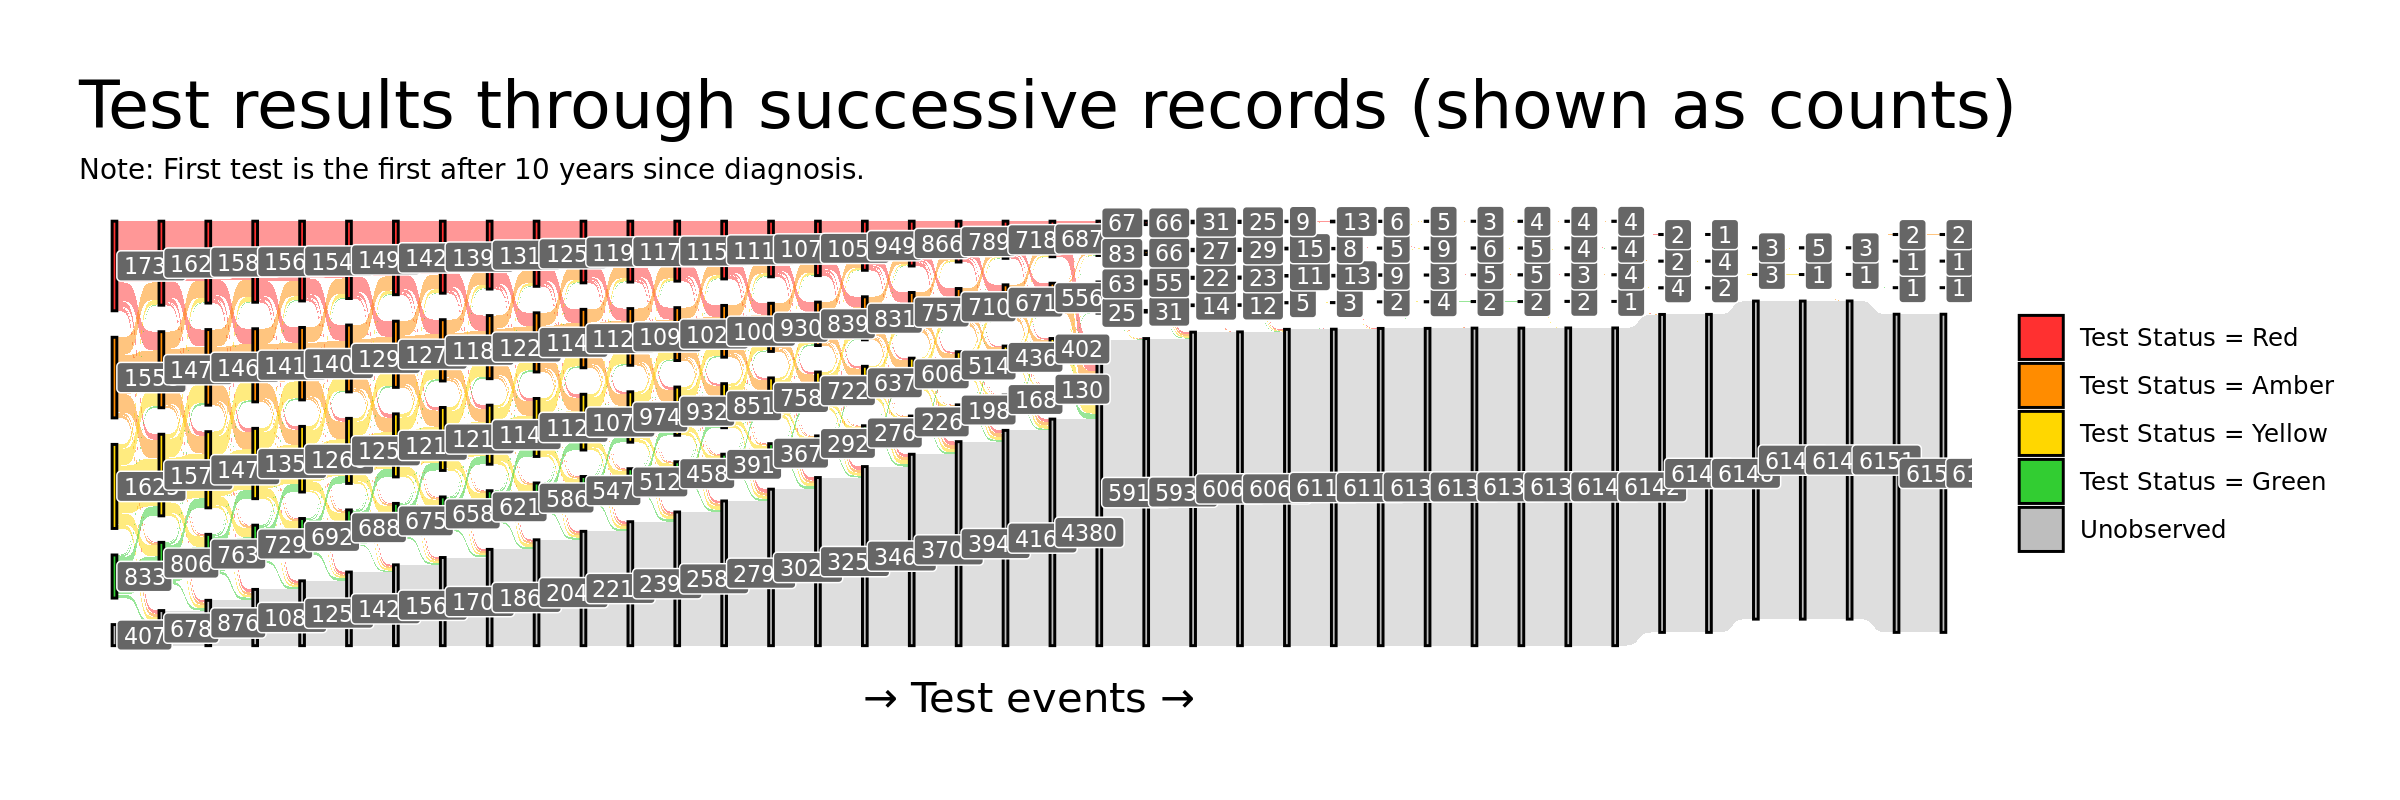

In [6]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# PLot.
options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

plot_testStatus_Sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    ggsankey::geom_sankey_label(
        aes(
          x = as.numeric(x) + .05,
          label = after_stat( paste0( freq ) )
        ),
        size = 8 / .pt, color = "white", fill = "gray40",
        hjust = 0
      ) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records (shown as counts)"
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey

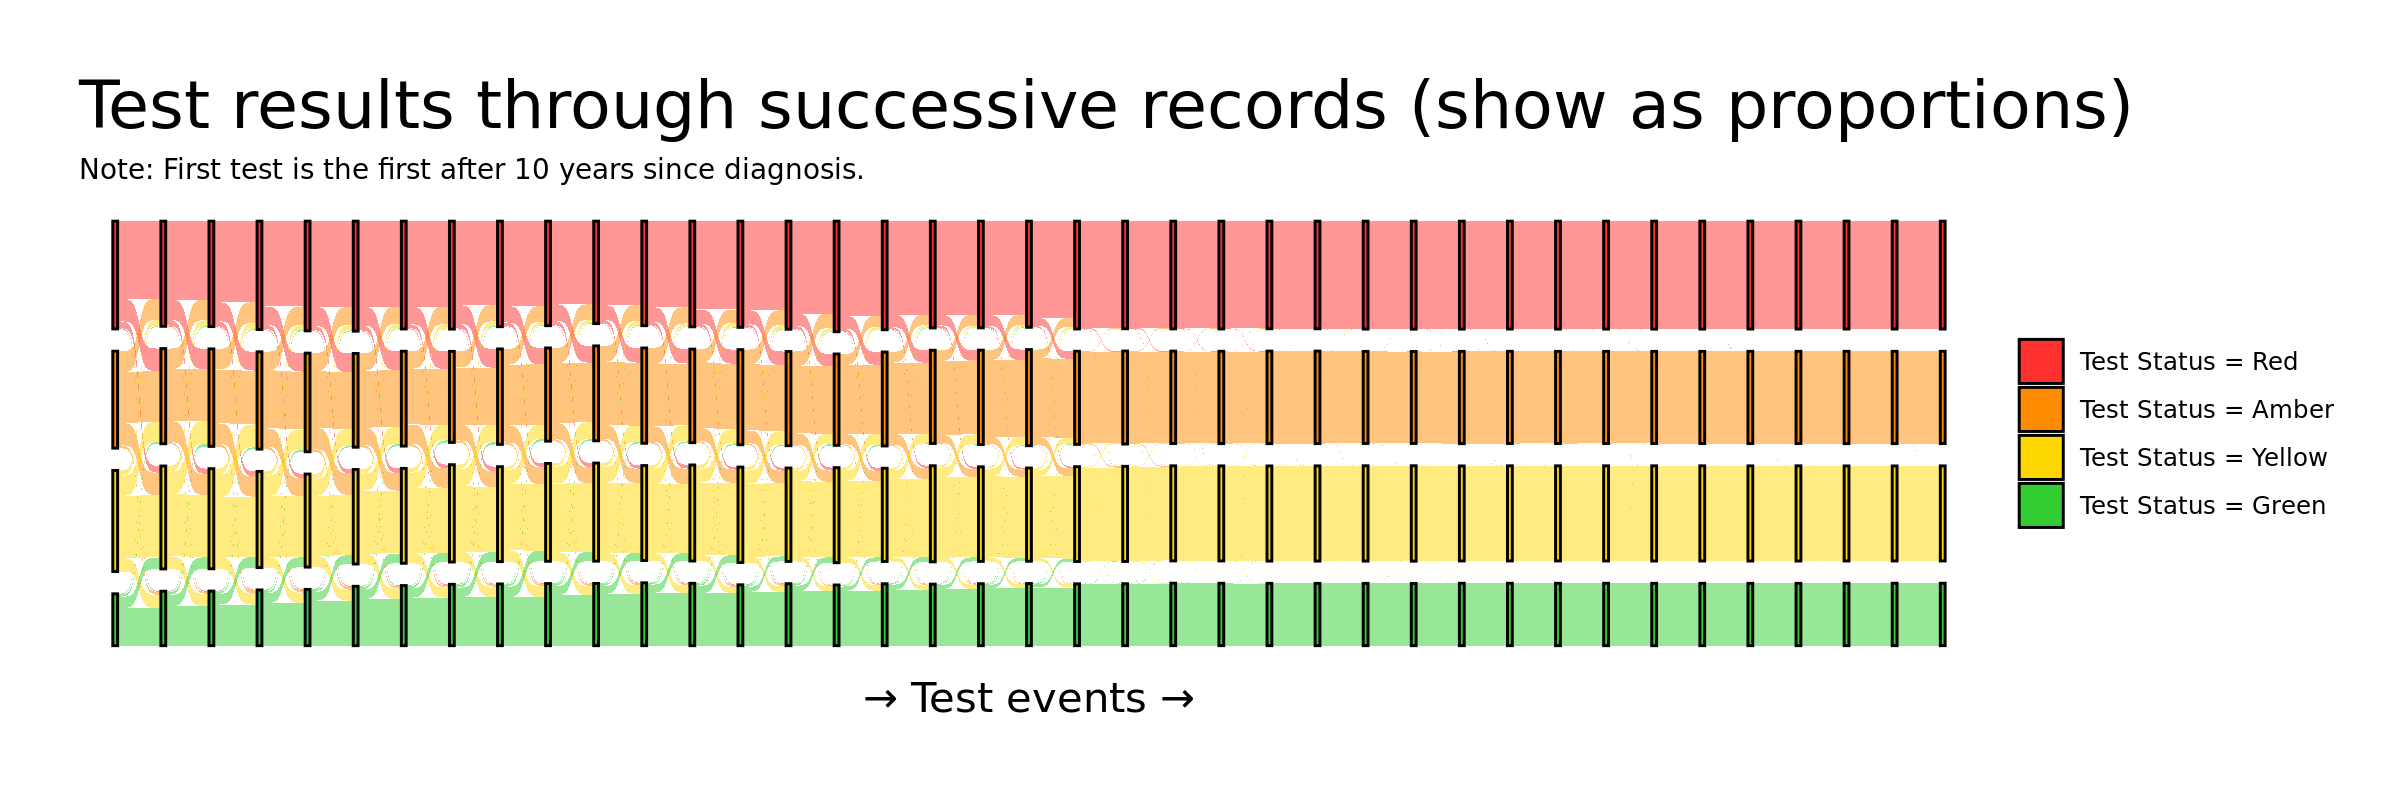

In [7]:
# Make plot data.
plotData <-
    sts_seqmine_test_only_excludingUnobserved %>%
    dplyr::select( -last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# PLot.
options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

plot_testStatus_Sankey_excludingUnobserved <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1 ) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records (show as proportions)"
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_excludingUnobserved

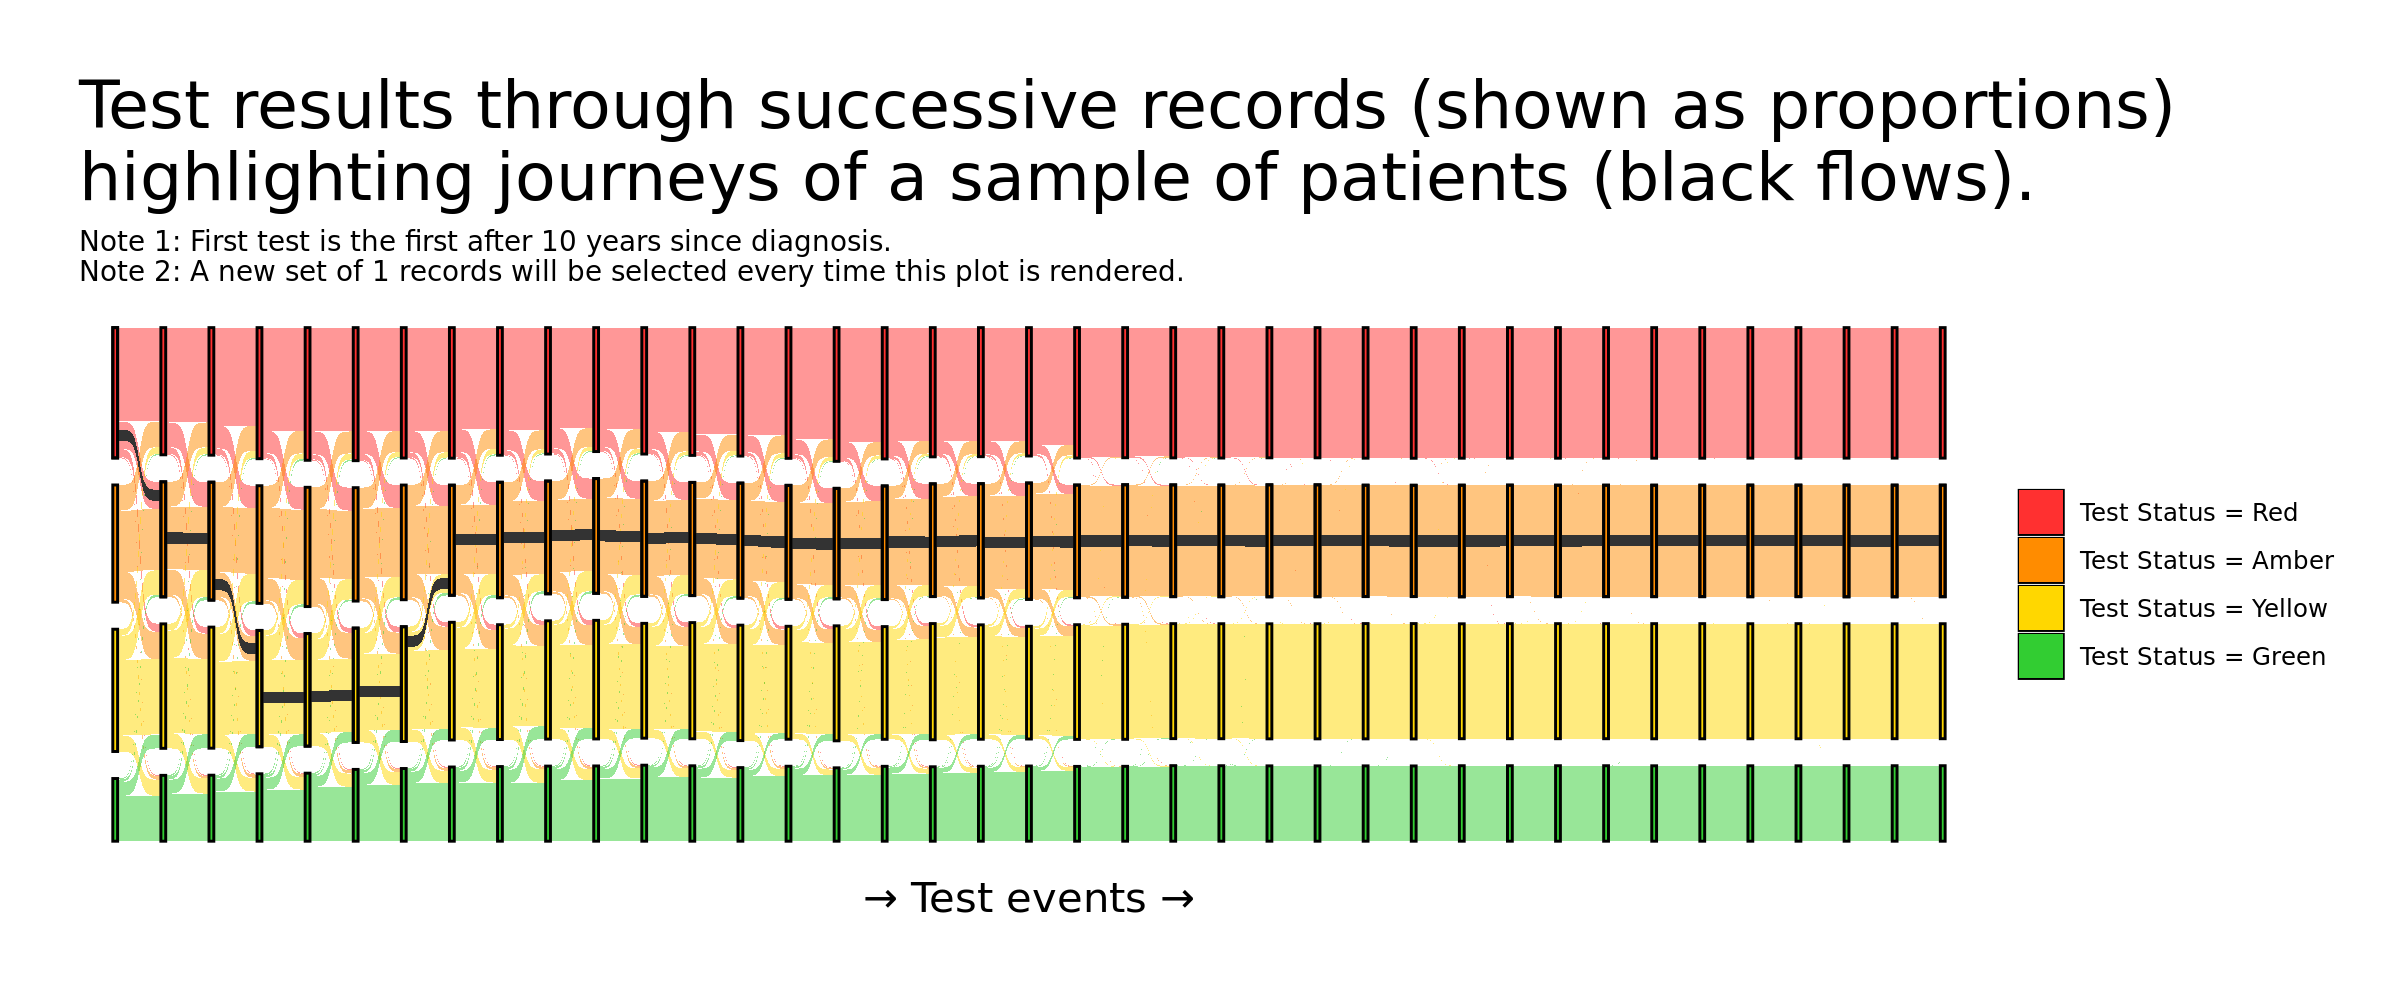

In [8]:
# Set plot parameters.
n_records_to_sample <- 1

# Make plot data.
plotData <-
    sts_seqmine_test_only_excludingUnobserved %>%
    dplyr::select( -last_col() ) %>%
    ggsankey::make_long( colnames( . ), subset.logic = "random", n.random = n_records_to_sample ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# PLot.
options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

plot_testStatus_Sankey_excludingUnobserved <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1 ) +
    ggsankey::geom_sankey_subset( mapping = ggplot2::aes( subset.idx = subset.idx ) ) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records (shown as proportions)\nhighlighting journeys of a sample of patients (black flows)."
        ,subtitle = paste0(
            "Note 1: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n"
            ,"Note 2: A new set of ", n_records_to_sample," records will be selected every time this plot is rendered."
        )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_excludingUnobserved

Some observations from the Test Statuses Sankey diagram:

1. __The overall count of patient records in each level of Test Status is approximately stable.__

    - Evidenced by little variation in the height of the vertical bars in the plots of proportions over time.
    
2. __The Test Status levels that change between every test event rarely change by more than one level.__

    - Evidenced by the barely-visible flows linking bars at subsequent test points that are not vertically adjacent.
    

#### States strata

In the next plots, I visualise the counts and proportions of patient records moving between states.

State stratification is based on [Glasziou, Irwig, and Mant (2005)](https://www.bmj.com/content/330/7492/644.long). There are three infomed by two components: the testing interval since the previous test {'Expected', 'Shorter-than-expected'}, and the change in prescriptions compared with the previous testing interval {'No observed change', 'Observed change'}. The three states are (0,0)-"in control"; (1,0)-"remeasure"; (0 or 1,1)-"action".

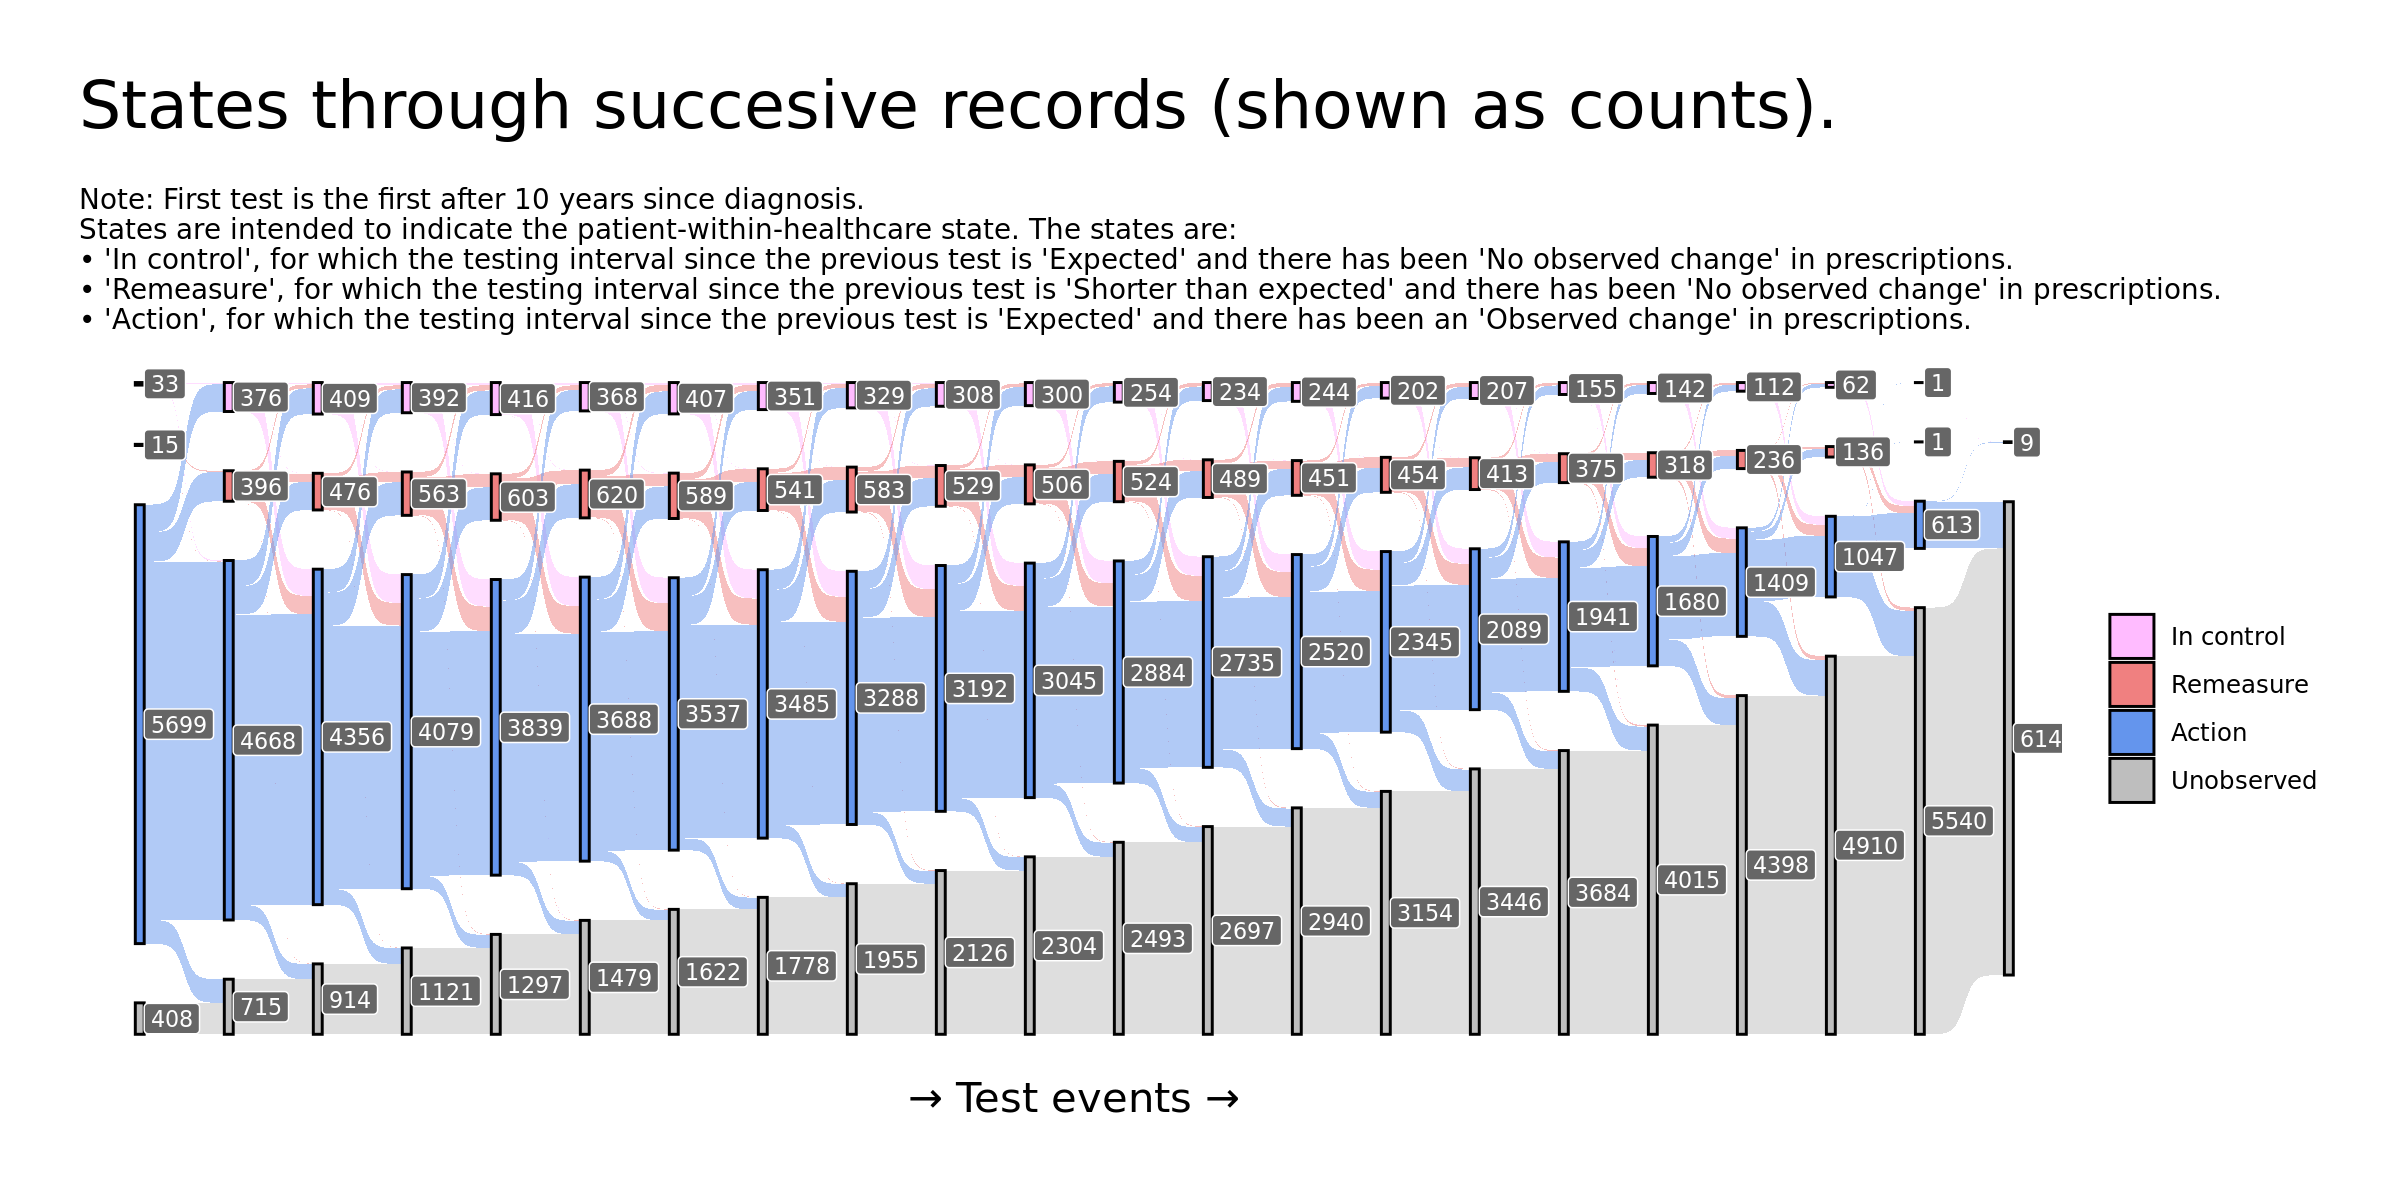

In [9]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    ggsankey::geom_sankey_label(
        aes(
          x = as.numeric(x) + .05,
          label = after_stat(paste0(freq))
        ),
        size = 8 / .pt, color = "white", fill = "gray40",
        hjust = 0
      ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "In control", "Remeasure", "Action", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records (shown as counts)."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'In control', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Remeasure', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Action', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey

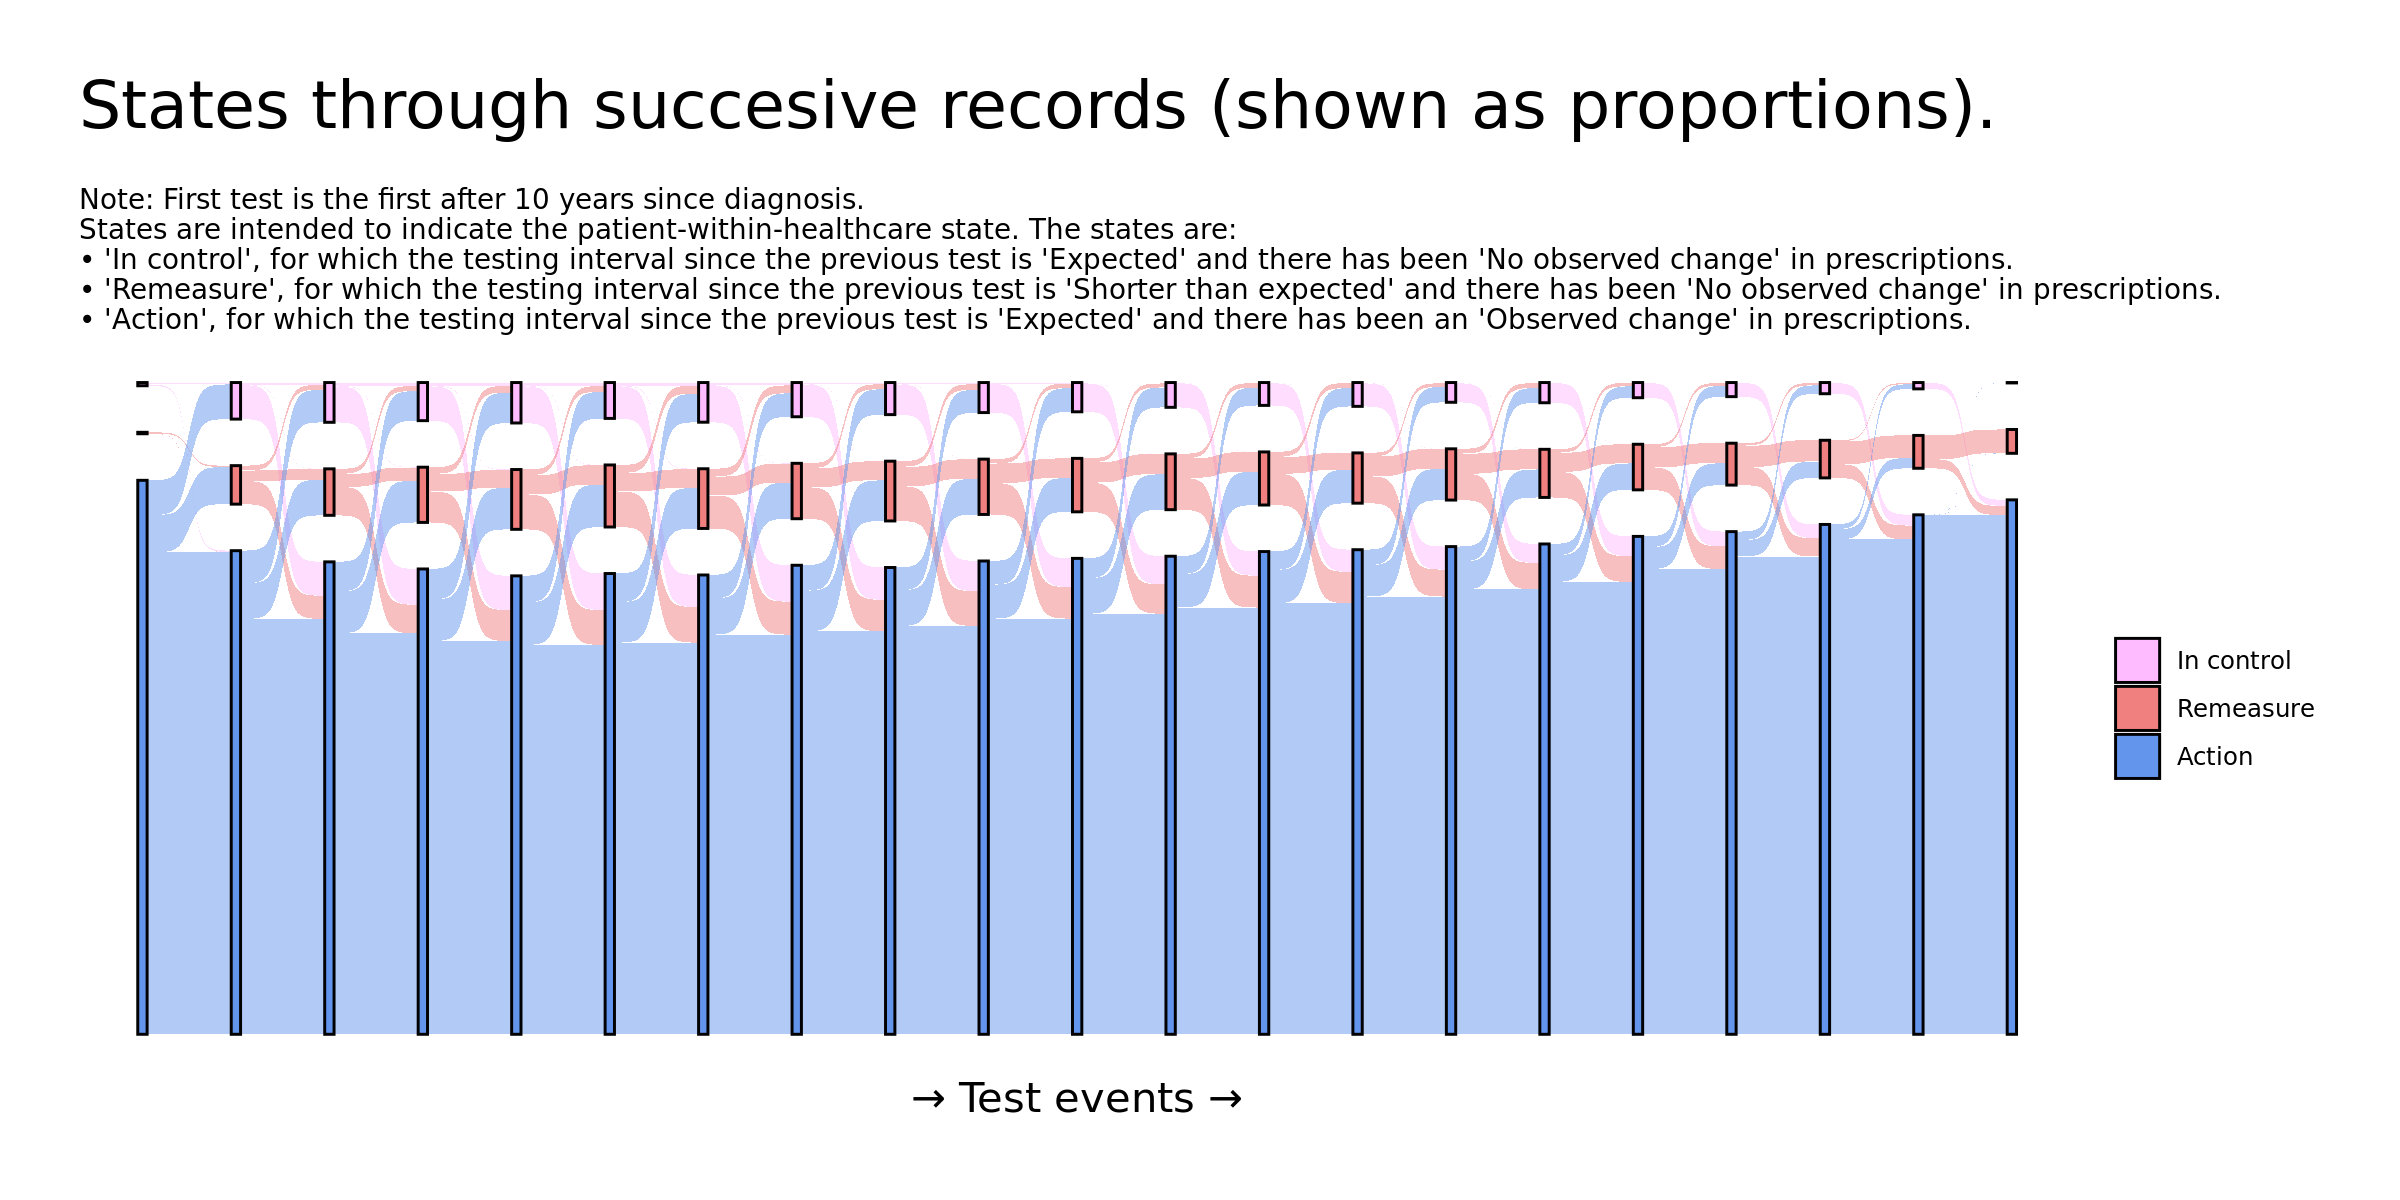

In [10]:
# Make plot data.
plotData <-
    sts_seqmine_HMA_excludingUnobserved %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_excludingUnobserved <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "In control", "Remeasure", "Action", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records (shown as proportions)."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'In control', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Remeasure', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Action', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_excludingUnobserved

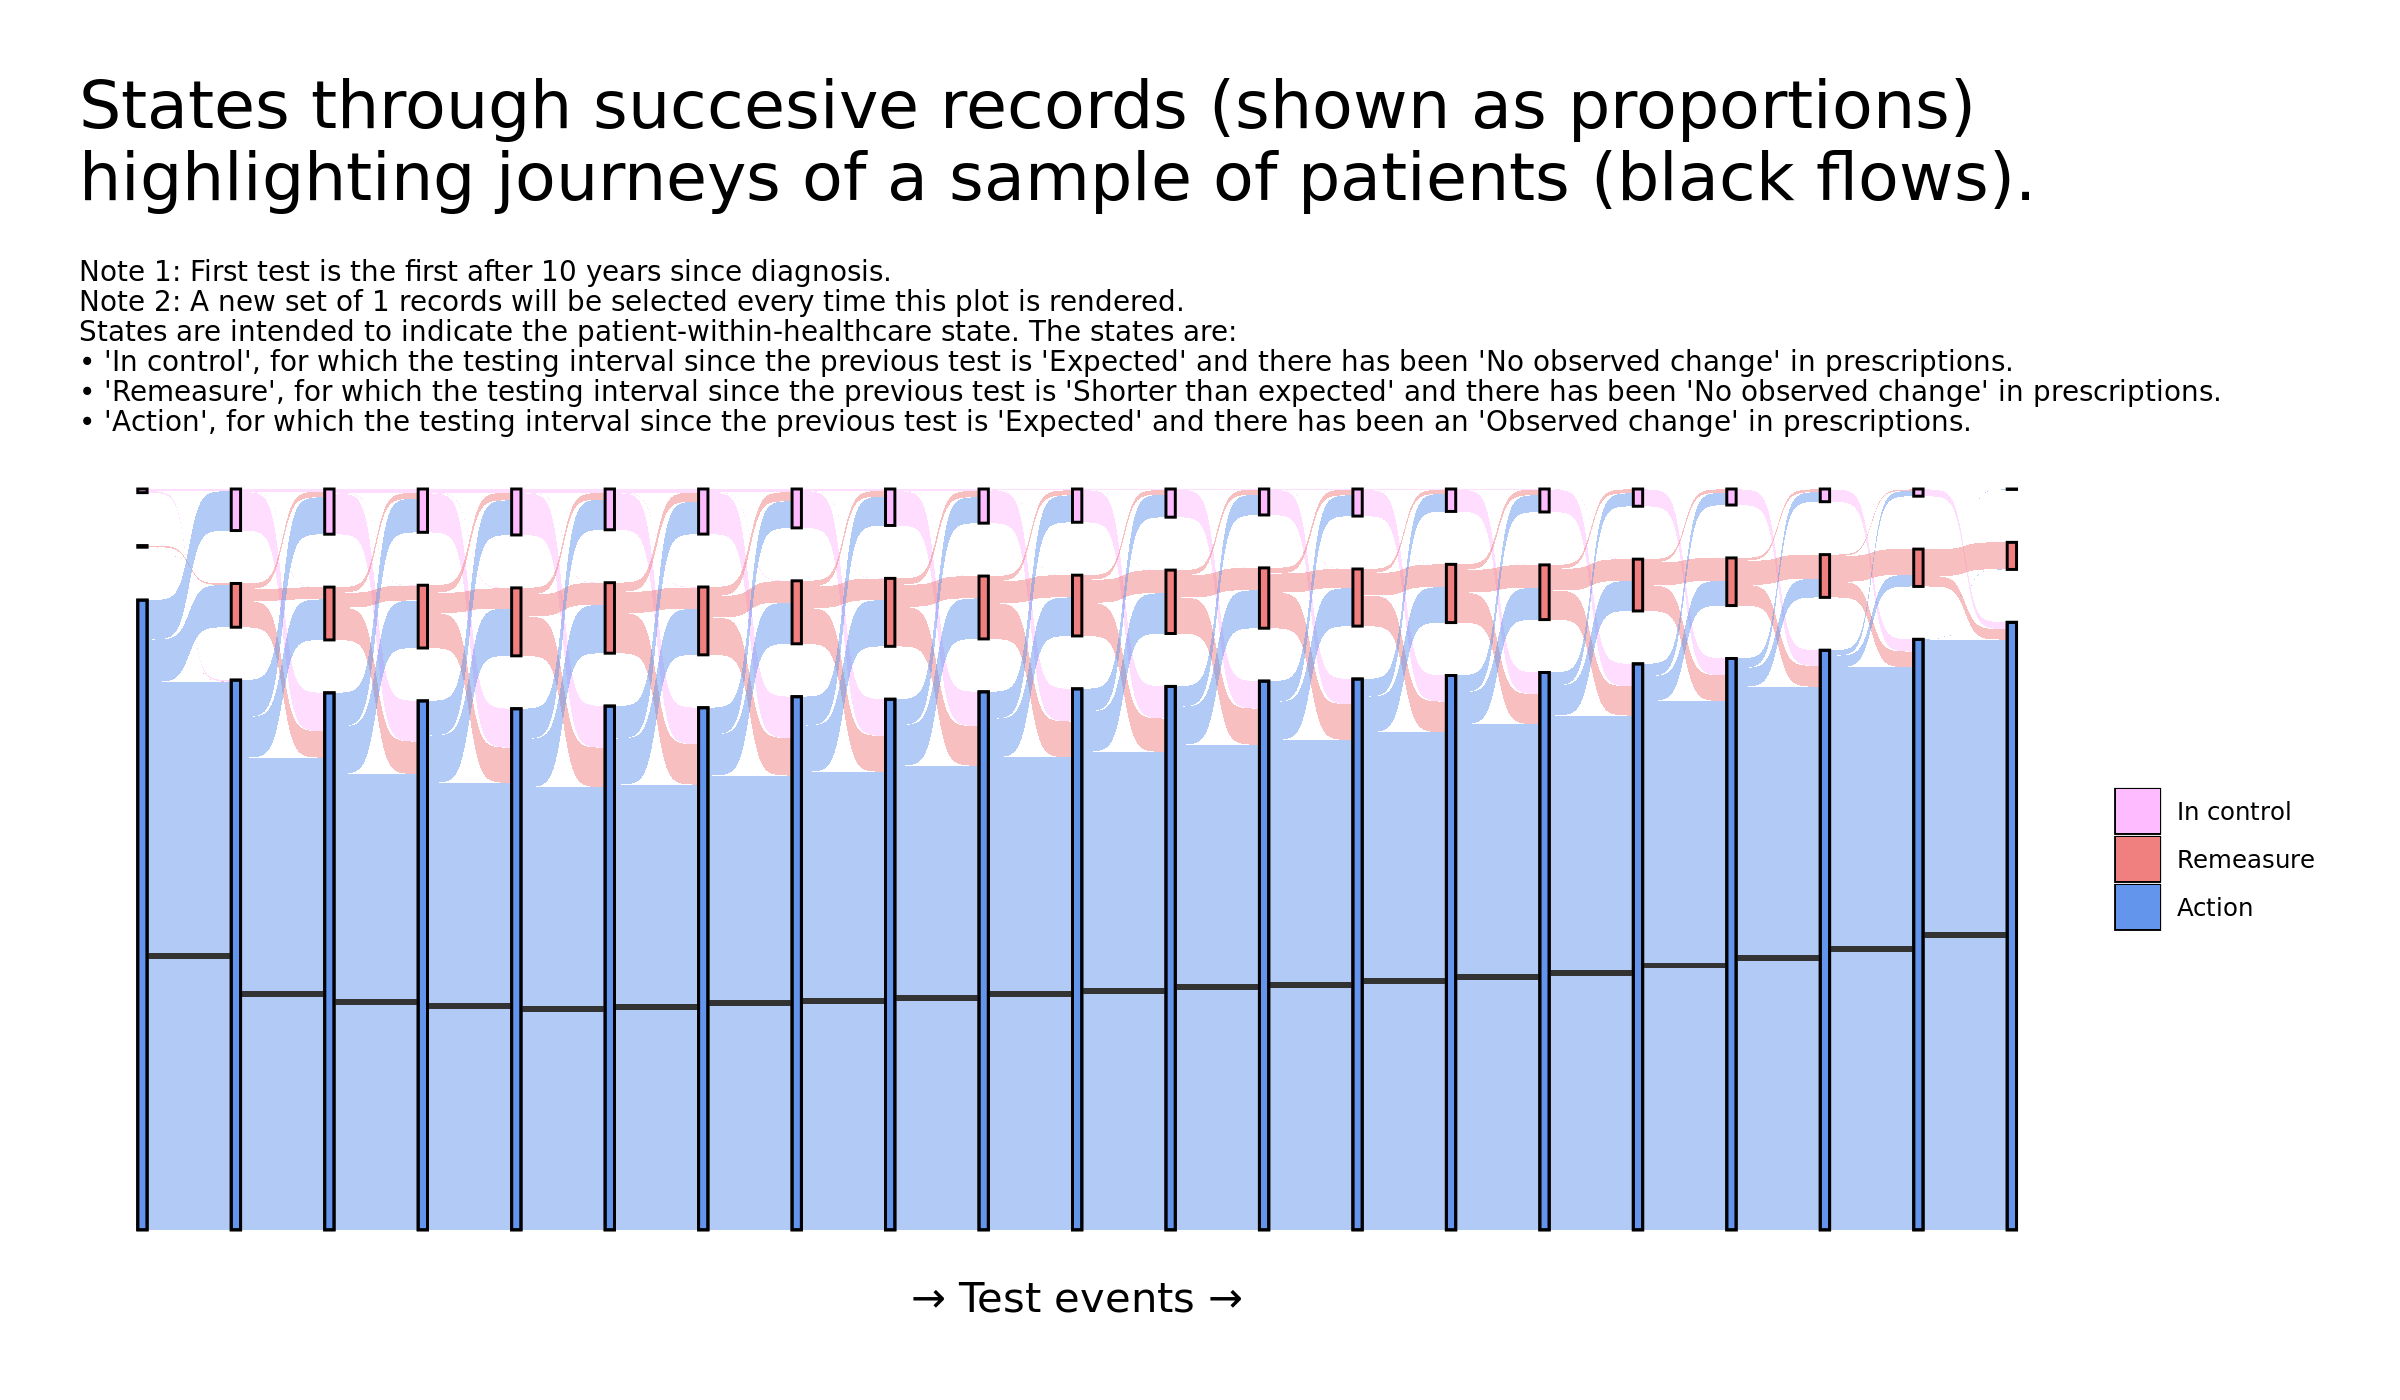

In [11]:
# Set plot parameters.
n_records_to_sample <- 1

# Make plot data.
plotData <-
    sts_seqmine_HMA_excludingUnobserved %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ), subset.logic = "random", n.random = n_records_to_sample ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Plot.
options( repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 200 )

plot_HMA_Sankey_excludingUnobserved <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    ggsankey::geom_sankey_subset( mapping = ggplot2::aes( subset.idx = subset.idx ), range.scalar = 0.01 ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "In control", "Remeasure", "Action", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records (shown as proportions)\nhighlighting journeys of a sample of patients (black flows)."
        ,subtitle = paste0(
            "\nNote 1: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n"
            ,"Note 2: A new set of ", n_records_to_sample," records will be selected every time this plot is rendered.\n"
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'In control', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Remeasure', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Action', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_excludingUnobserved

Some observations from the state Sankey diagram:

1. __Most patient records indicate an 'Action' strategy throughout.__

    - Evidenced by the 'Adjust' vertical bars being the largest throughout.
    
2. __States are always in flux.__

    - Evidenced by flows to adjacent vertical bars throughout.
    
3. __The 'Action' state is the only state whose membership grows over time.__

    - Evidenced by the increase in the height of the blue bars from left to right.
    

#### Test Status and State strata

In the next plots, I visualise the counts and proportions of patient records moving through test statues and state.

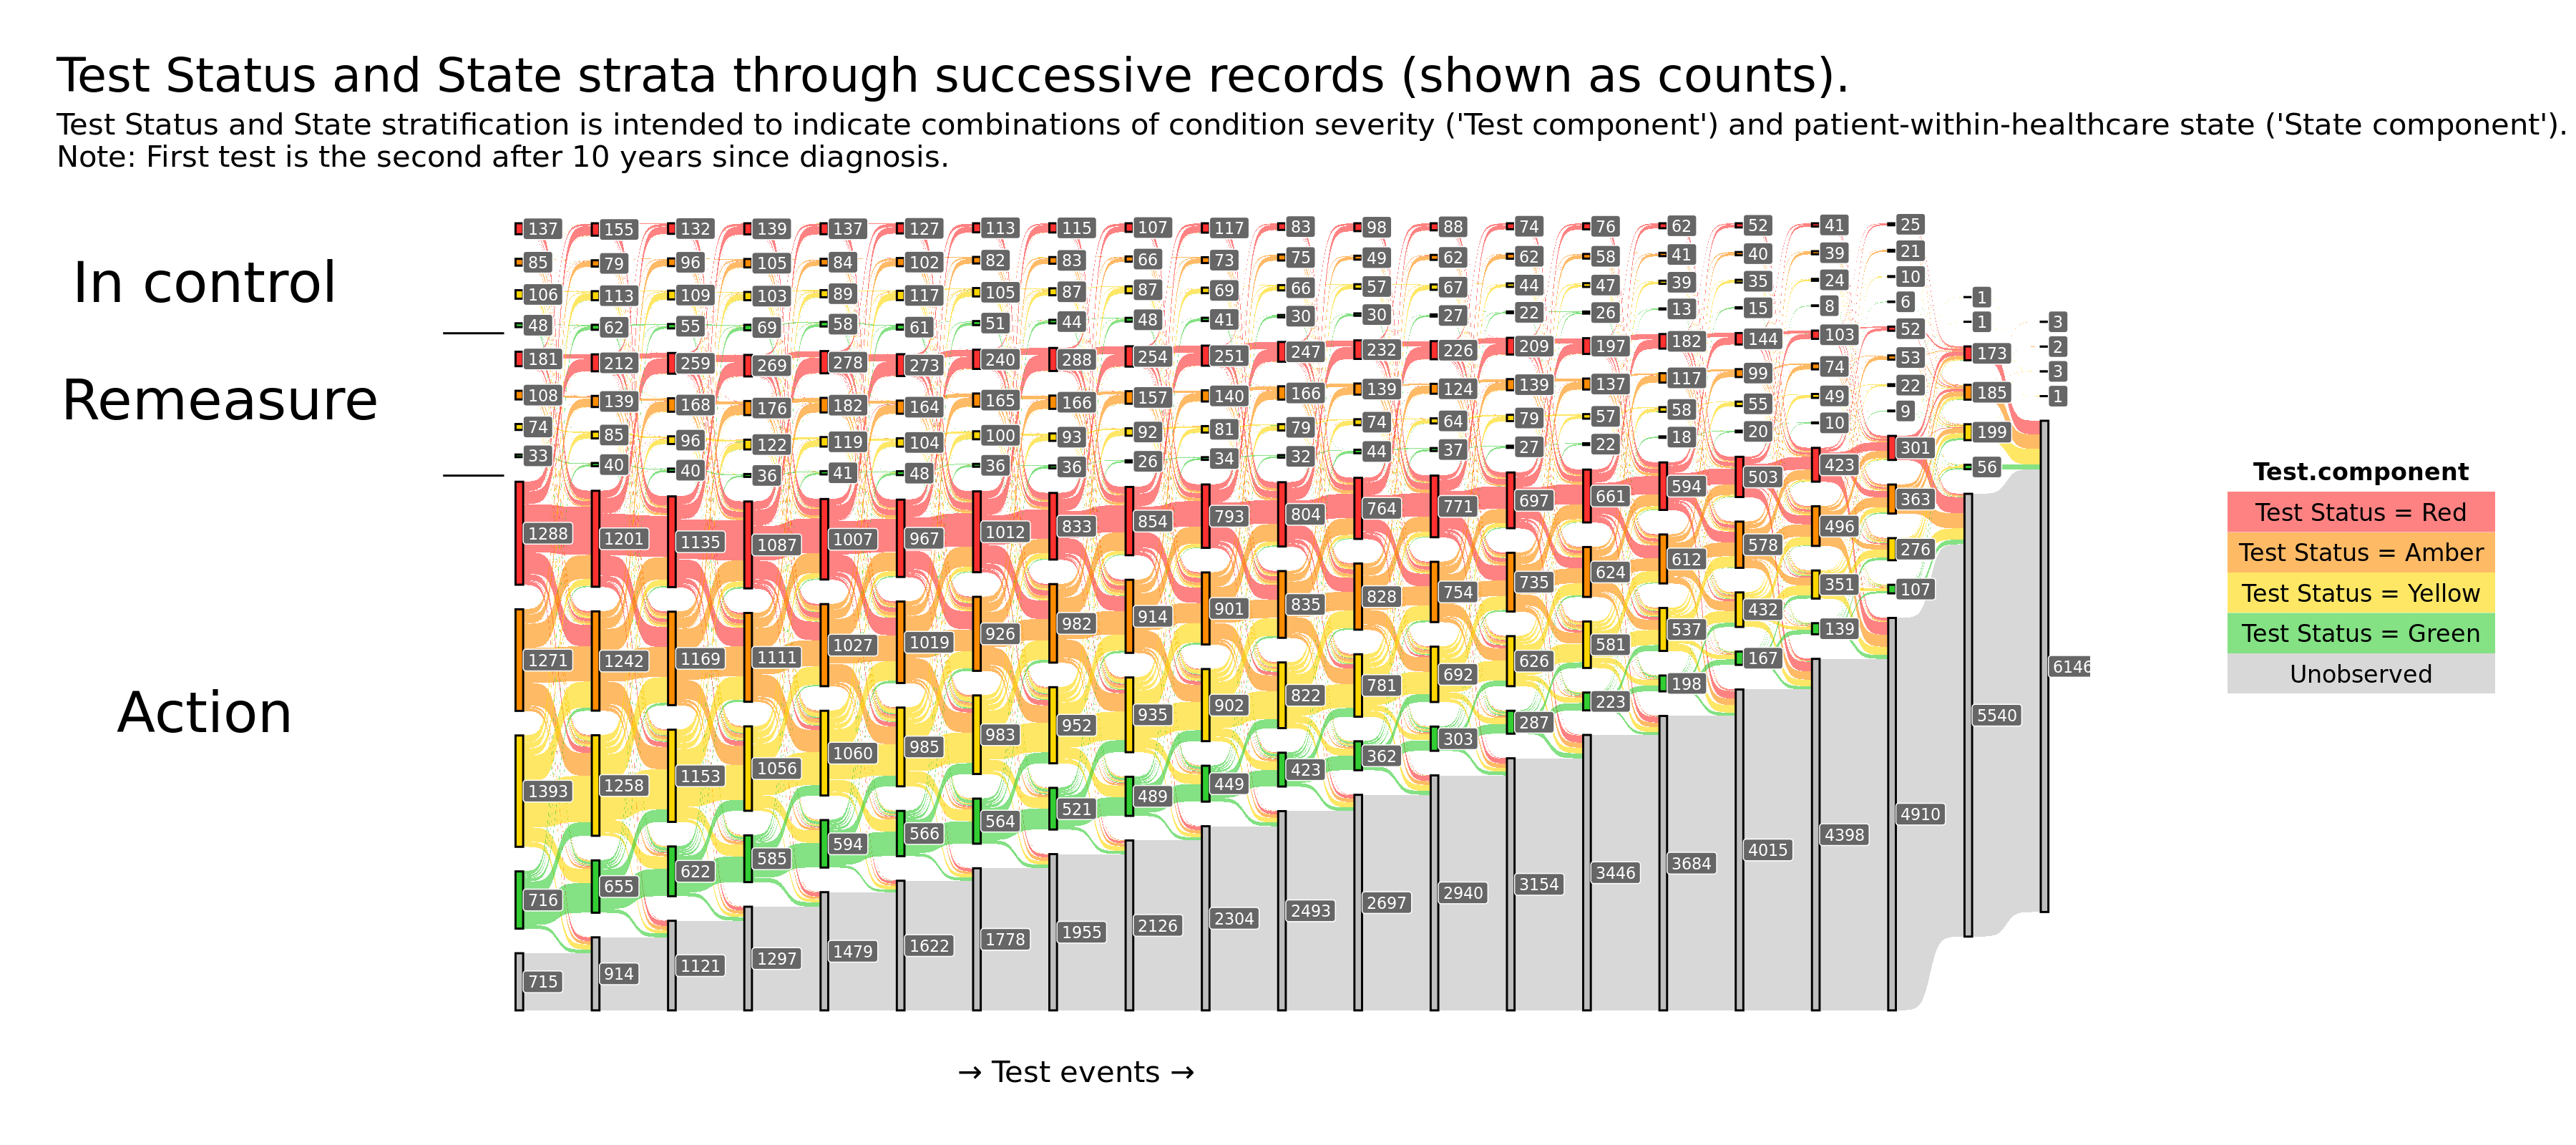

In [12]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate( group = 1 ) %>%
    dplyr::select( - next_x, - next_node, - next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
n_patients_Unobserved_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Unobserved" ) ) %>% nrow()
y_segment_Adjust <- n_patients_Adjust_at_start + n_patients_Unobserved_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -5, label = "\t\tIn control", size = 10, y = y_label_Hold ) +
    annotate("text", x = -4.8, label = "\t\tRemeasure", size = 10, y = y_label_Monitor ) +
    annotate("text", x = -5, label = "\t\tAction", size = 10, y = y_label_Adjust ) +
    # Overlay count labels.
    ggsankey::geom_sankey_label(
        aes(
          x = as.numeric(x) + .05,
          label = after_stat(paste0(freq))
        ),
        size = 8 / .pt, color = "white", fill = "gray40",
        hjust = 0
      ) +
    labs(
        title = "Test Status and State strata through successive records (shown as counts)."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,paste0("Note: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    HMAandTestStatus_display_table %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_tail( n = 5 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey ) )

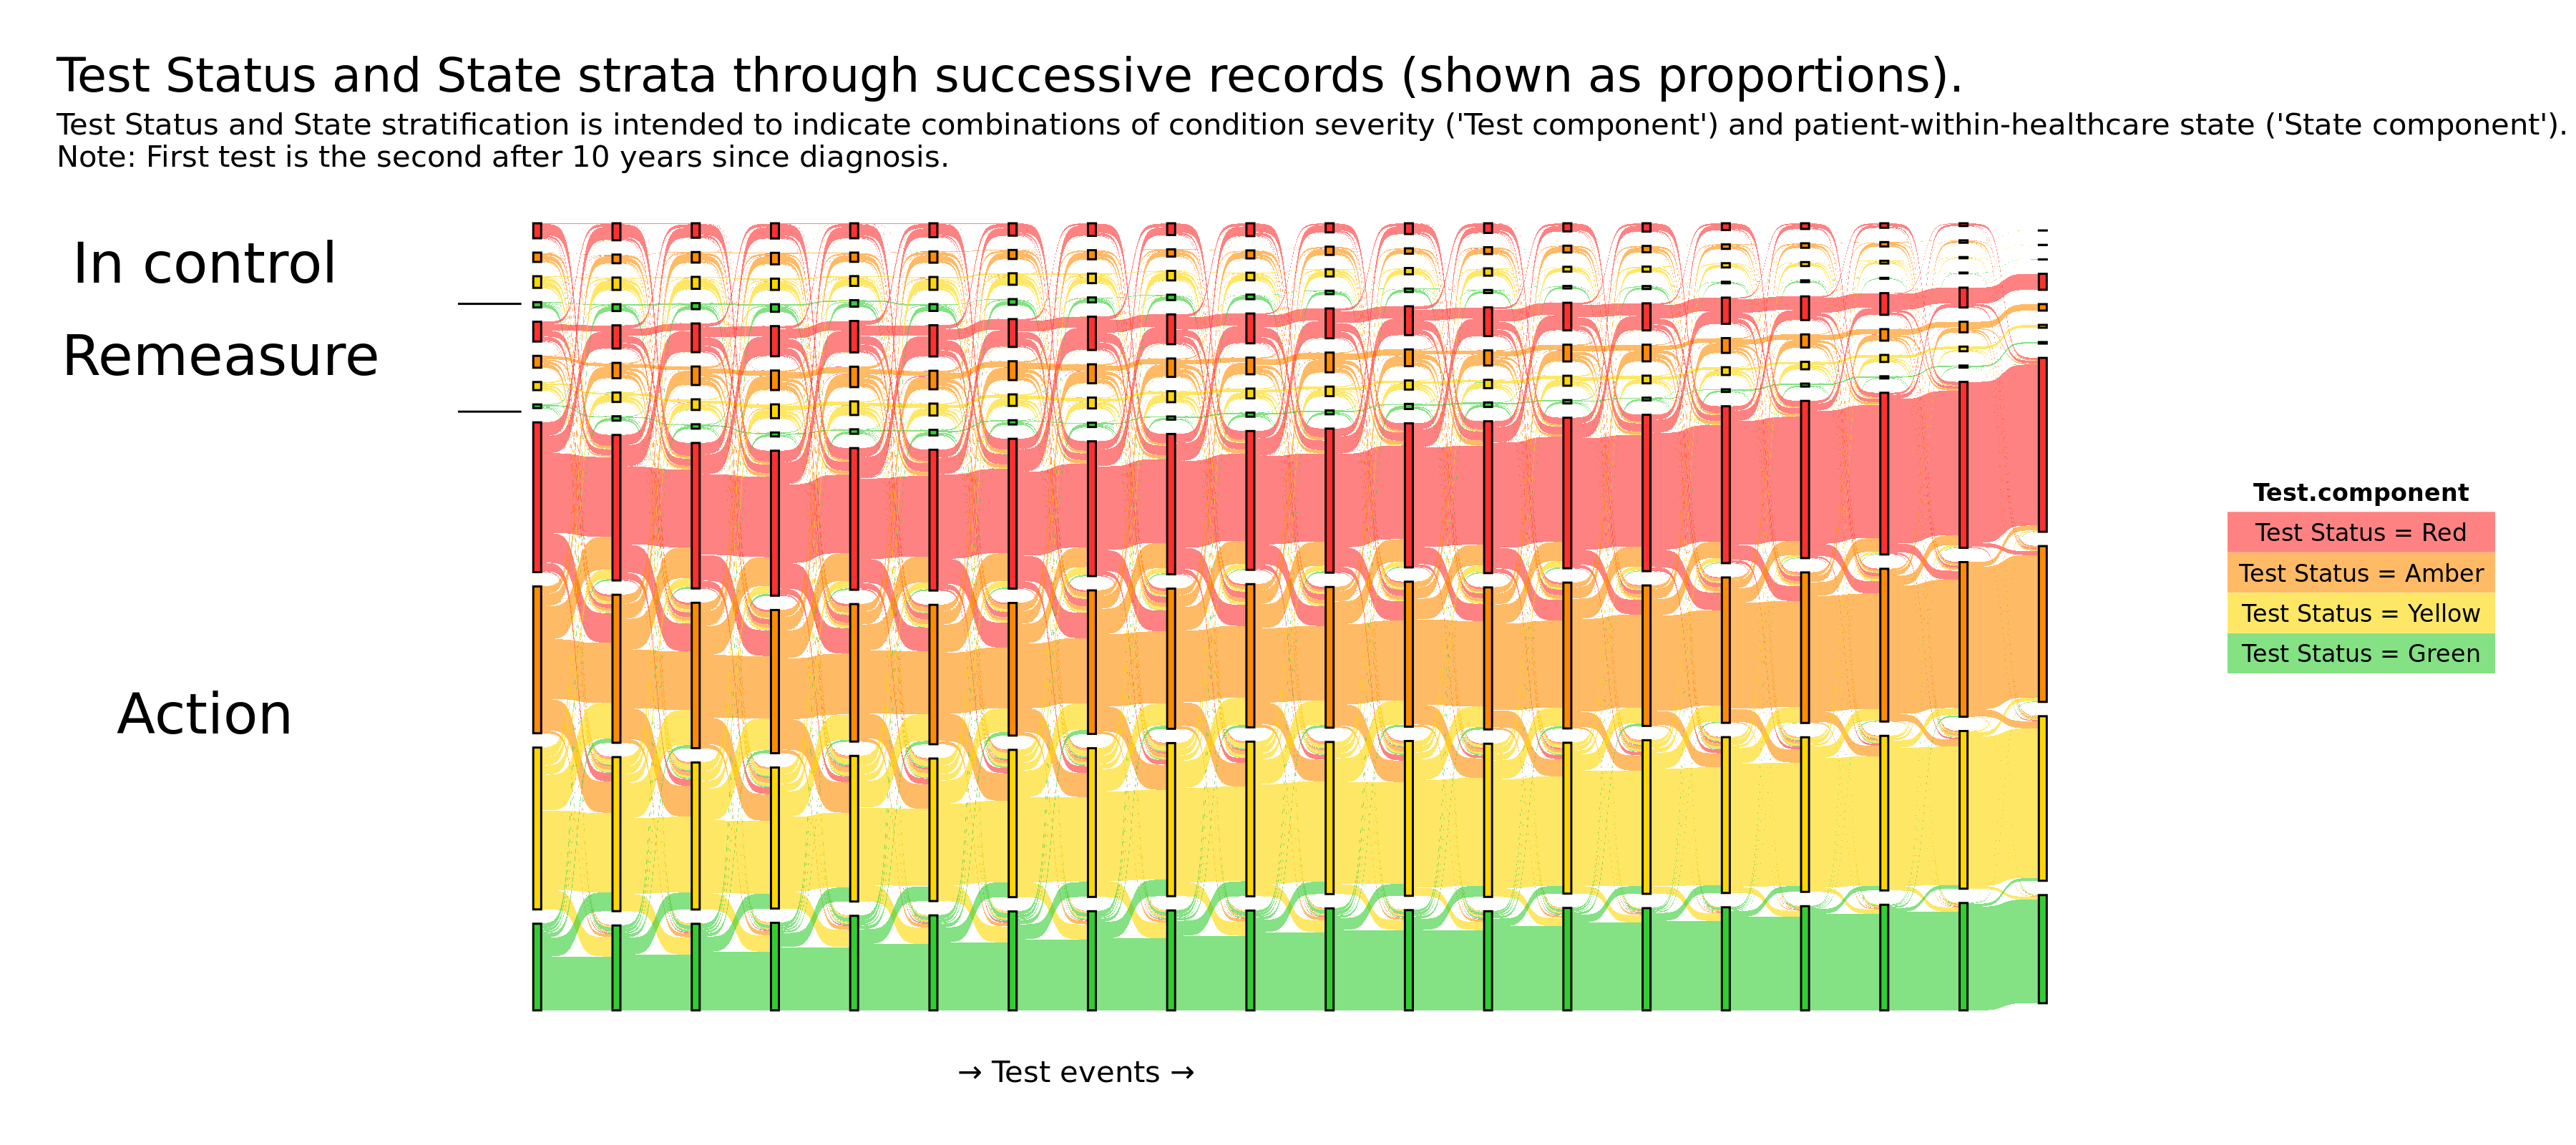

In [13]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus_excludingUnobserved %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate(group = 1) %>%
    dplyr::select(-next_x, -next_node, -next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -5, label = "\t\tIn control", size = 10, y = y_label_Hold ) +
    annotate("text", x = -4.8, label = "\t\tRemeasure", size = 10, y = y_label_Monitor ) +
    annotate("text", x = -5, label = "\t\tAction", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records (shown as proportions)."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
               ,paste0("Note: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    scale_y_continuous( breaks = seq(-5000,5000,500) ) +
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table_excludingUnobserved <-
    HMAandTestStatus_display_table %>%
    dplyr::filter( Test.component != "Unobserved" ) %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_head( n = 4 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_head( n = 4 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_excludingUnobserved <-
    cowplot::plot_grid(
        plot_sankey, plot_table_excludingUnobserved
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_excludingUnobserved ) )

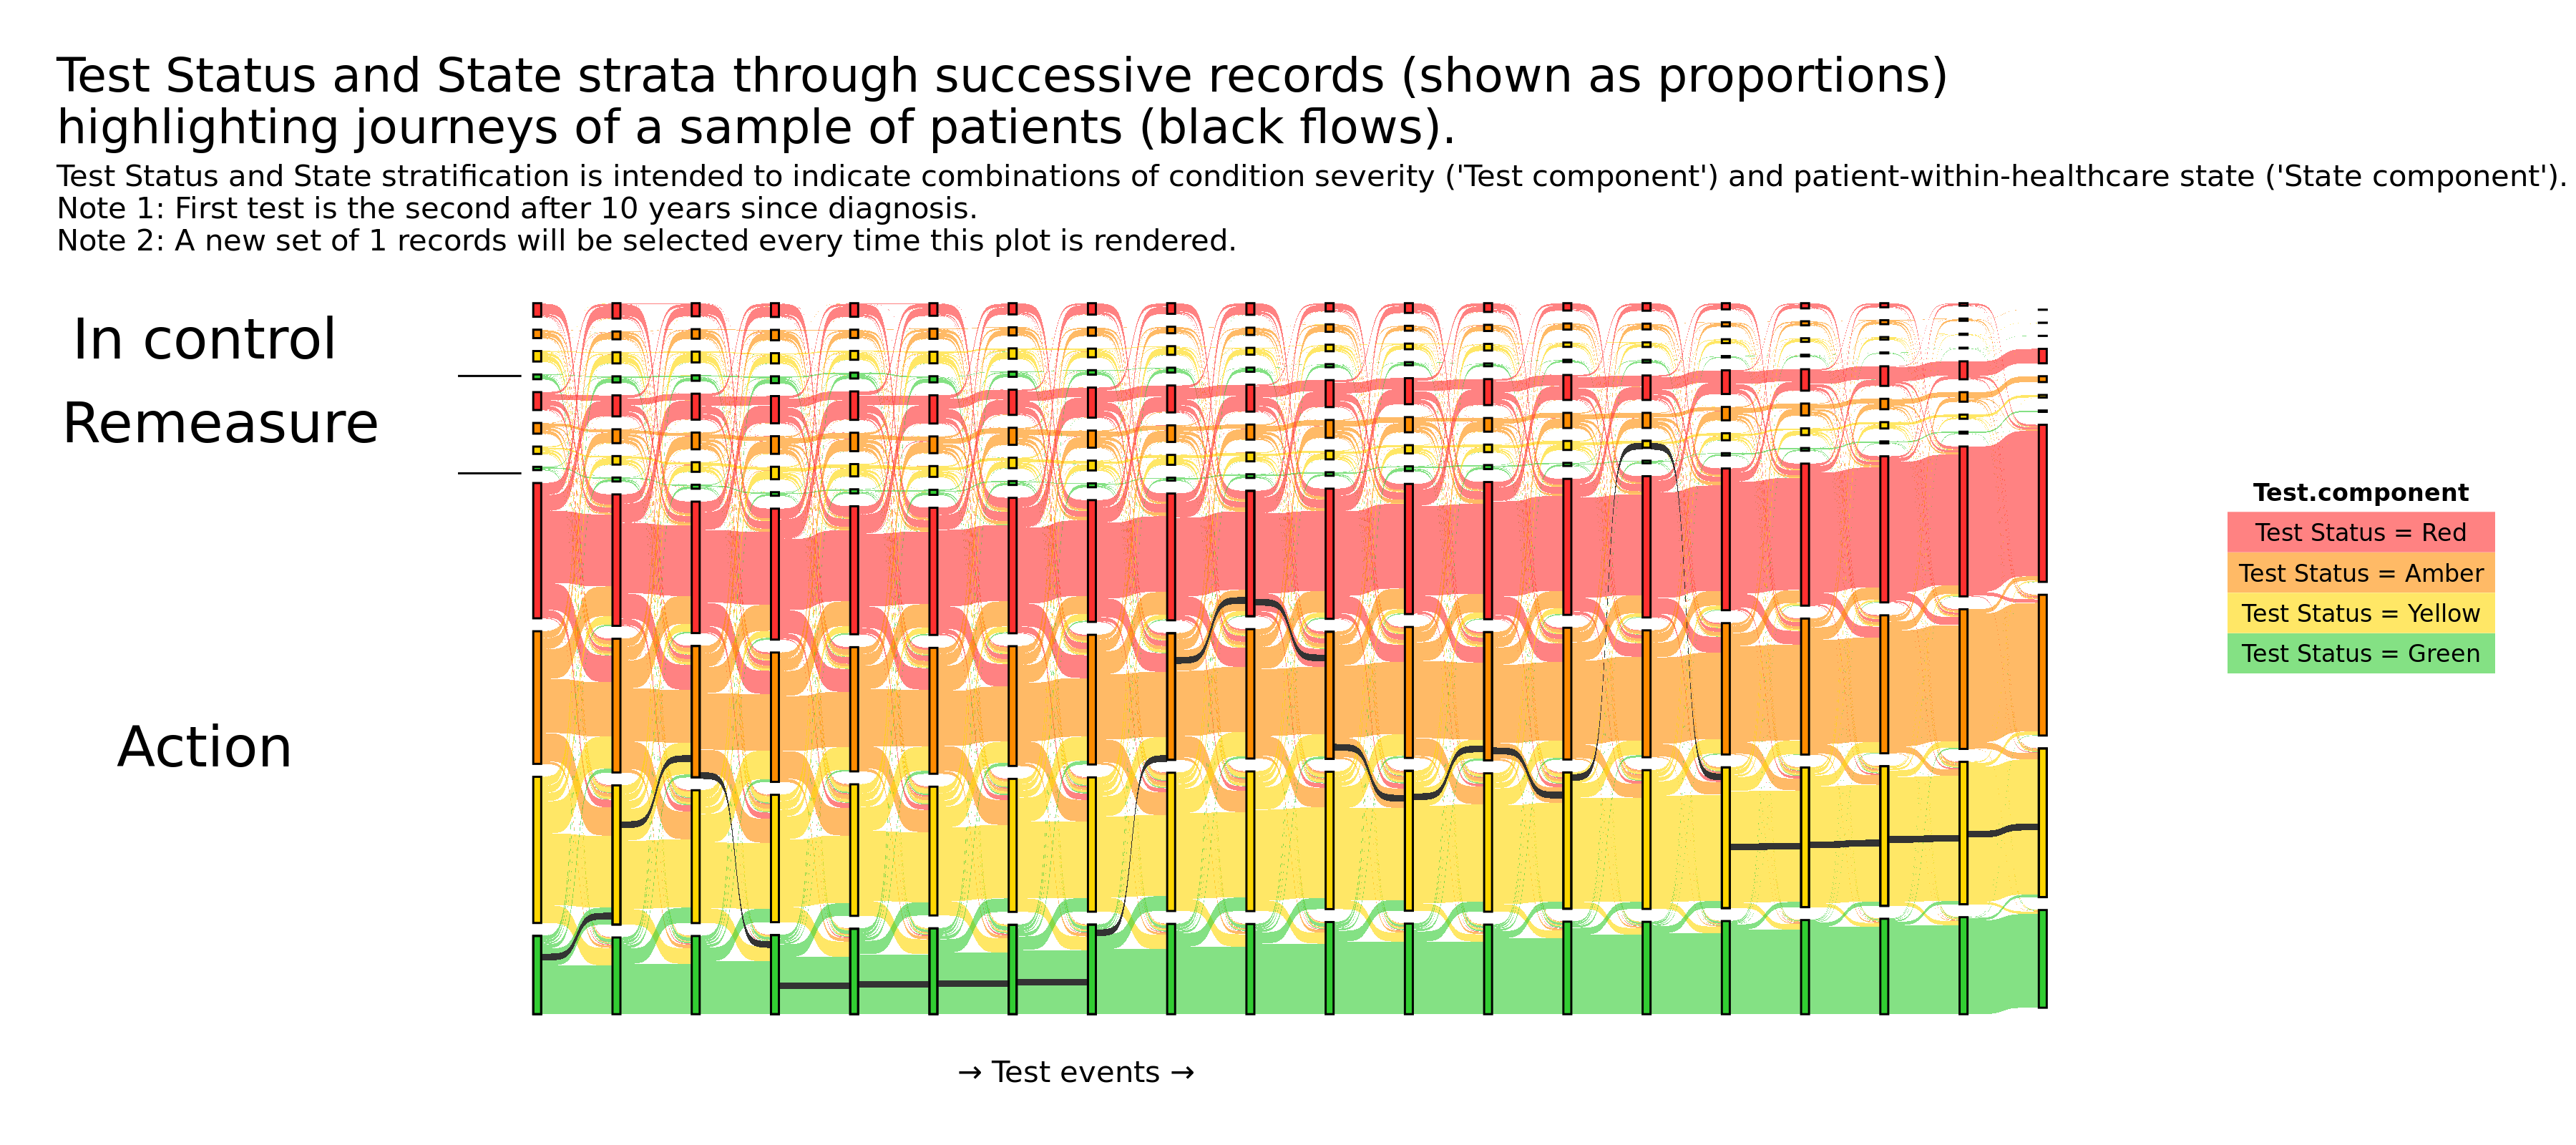

In [14]:
# Set plot parameters.
n_records_to_sample <- 1

# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus_excludingUnobserved %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ), subset.logic = "random", n.random = n_records_to_sample ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate(group = 1) %>%
    dplyr::select(-next_x, -next_node, -next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    ggsankey::geom_sankey_subset( mapping = ggplot2::aes( subset.idx = subset.idx ), range.scalar = 0.05 ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -5, label = "\t\tIn control", size = 10, y = y_label_Hold ) +
    annotate("text", x = -4.8, label = "\t\tRemeasure", size = 10, y = y_label_Monitor ) +
    annotate("text", x = -5, label = "\t\tAction", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records (shown as proportions)\nhighlighting journeys of a sample of patients (black flows)."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,"Note 1: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n"
                ,"Note 2: A new set of ", n_records_to_sample," records will be selected every time this plot is rendered."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    scale_y_continuous( breaks = seq(-5000,5000,500) ) +
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table_excludingUnobserved <-
    HMAandTestStatus_display_table %>%
    dplyr::filter( Test.component != "Unobserved" ) %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_head( n = 4 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_head( n = 4 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_excludingUnobserved <-
    cowplot::plot_grid(
        plot_sankey, plot_table_excludingUnobserved
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_excludingUnobserved ) )

Some observations from the Test Status-and-State Sankey diagrams:

1. __Distributions of test status are quite similar across time in all states, with the exception of a larger initial proportion 'Red' test status in the "remeasure" state.__

    - Evidenced by similar releative heights of vertical bares in each set of colours.
    
2. __The population proportions of a given test status are fairly constant.__

    - Evidenced by the height of the vertical bars remaining fairly constant, despite the 'in control' and 'Remeasure' bars all shrinking. 
    

# Quantifying the complexity of test status sequences

We quantified the complexity of patients’ test statuses when in each of the “in control”, “remeasure”, and “action” states using [(Gabadinho et al. 2010](https://www.researchgate.net/profile/Gilbert-Ritschard/publication/220786242_Indice_de_complexite_pour_le_tri_et_la_comparaison_de_sequences_categorielles/links/53edabdb0cf26b9b7dc5f259/Indice-de-complexite-pour-le-tri-et-la-comparaison-de-sequences-categorielles.pdf)) complexity index. The __Complexity Index__ statistic is the geometric mean of a scaled count of transitions in a sequence and the sequence's scaled longitudinal entropy. The count of transitions is scaled to the length of the sequence, and the longitundinal entropy is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet). For our simple situation, a = 5 because the test status can only be red, amber, yellow, or green, and an ‘Unobserved’ placeholder that we used once a patient’s journey had ended. It's range is between 0 and 1., with 1 indicate maximum complexity, i.e. changes through the entire range of values at every possible opportunity.

First, I plot the distribution of sequence complexity indices irrespective of state.

## Overall sequence complexity of test statuses, irrespective of changes in state

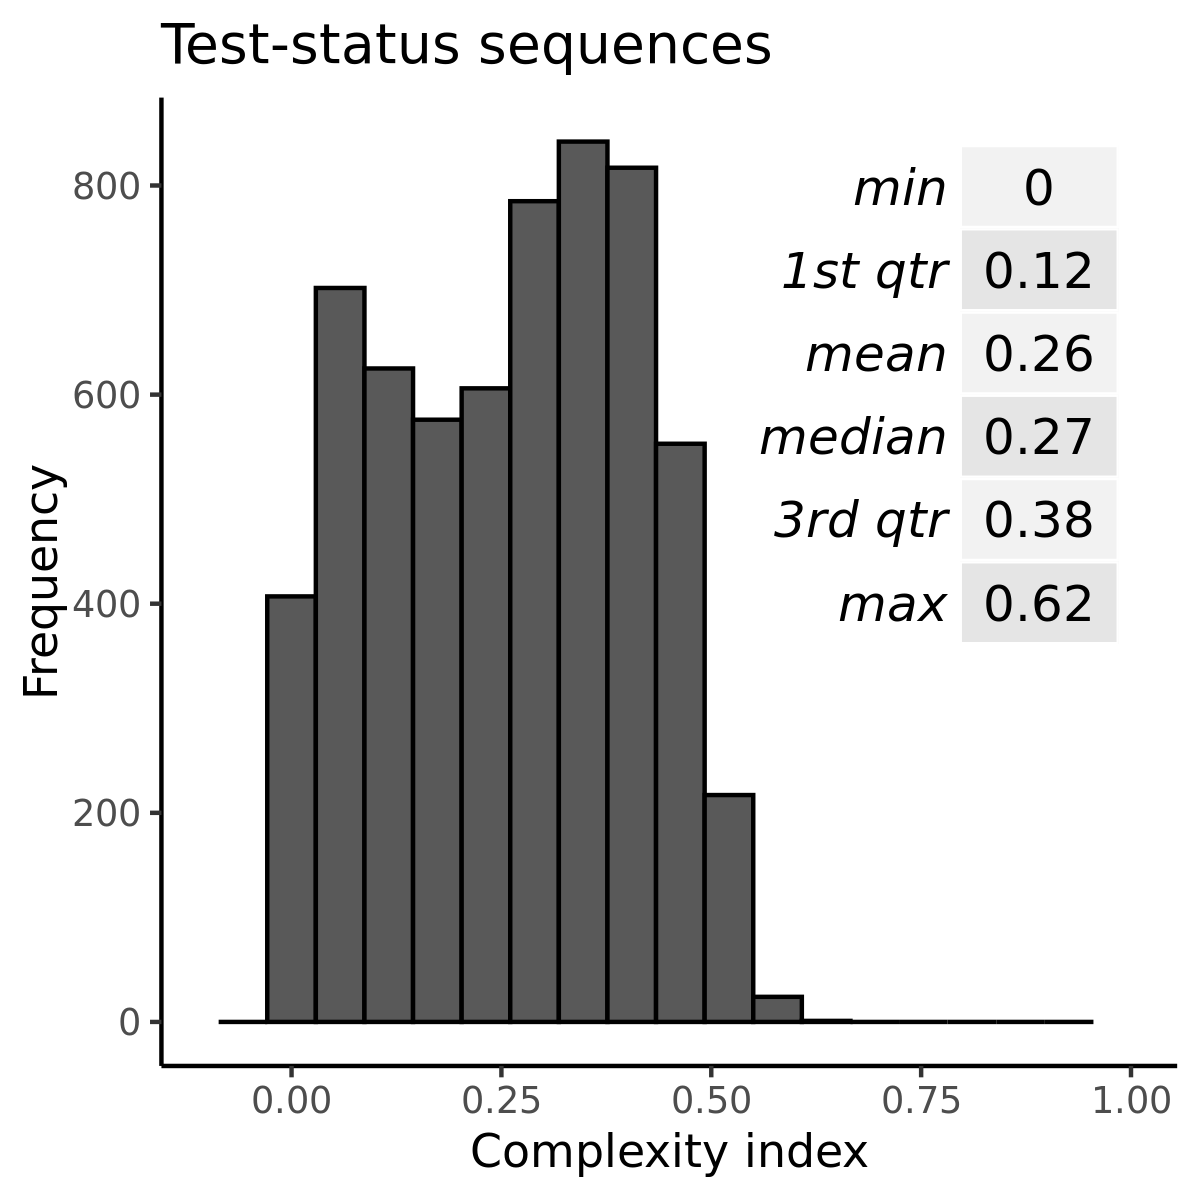

In [41]:
# Calculate statistics over all patient records.
seq_complexity_test_only <- TraMineR::seqici( sts_seqmine_test_only )

# Create table of summary statistics.
plot_table <-
   seq_complexity_test_only %>%
    as.data.frame() %>%
    dplyr::summarise(
        min = min( C )
        ,`1st qtr` = quantile( C, 0.25 )
        ,mean = mean( C )
        ,median = median( C )
        ,`3rd qtr` = quantile( C, 0.75 )
        ,max = max( C )
    ) %>%
    base::round(2) %>%
    t()

# Plot histograms and summary statistics.
options( repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300 )
n_bins <- 20
plot_sequenceComplexity_test_only <-
    seq_complexity_test_only %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Test-status sequences", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    annotation_custom( tableGrob( plot_table ), xmin = 0.5, xmax = 1, ymin = 300, ymax = 900 ) +
    theme_classic()

suppressWarnings( print( plot_sequenceComplexity_test_only ) )

The plot above shows that patient records are similarly likely to show moderate or low complexity.

This plot should be considered as context for complexity irrespective of state. Next, I stratify the sequences into subsequences of “in control”, “remeasure”, and “action” states. A patient record's subsequence is defined by consecutive test events within a state. For example, a pattern of 'In Control'|Green -> 'In Control'|Yellow -> 'Remeasure'|Yellow -> 'In Control'|Yellow contains three subsequences. The first subsequence is Green -> Yellow in an "in control" state; the second subsequence is Yellow in a "remeasure" state; the third subsequence is Yellow in an "in control" state. The first state has minimal complexity and the latter two have zero complexity.

Note that the previous calculations for complexity irrespective of state provided a complexity-index value for each patient's entire health-record sequence, but the following calculations will provide a complexity-index value for each _subsequence_ found in each patient's health-record sequence.

## State-specific subsequence complexity of test statuses

In [16]:
# Define list of events to focus on.
events_selection <-
    df_event_factor %>%
    dplyr::select( event_fct_order ) %>%
    dplyr::filter( stringr::str_detect( event_fct_order, pattern = "(Test)" ) | event_fct_order == "Unobserved" ) %>%
    droplevels() %>%
    dplyr::pull()

# Cut/Stratify/Split time series object by state (within patient).
df_seq_test_only_stratified_by_state <-
    df_seq_test_only %>%
    dplyr::select( person_id, HMA, event_value, rn ) %>%
    base::split( .$HMA)

# Convert the time series objects to state sequence objects.
# ## Hold
person_subsequences_Hold <- 
    df_seq_test_only_stratified_by_state$Hold %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Hold <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Hold
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = person_subsequences_Hold %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Hold, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Hold <-
    d_Hold %>%
    TraMineR::seqdef( labels = statl) %>%#events_selection[ events_selection %in% statl ] ) %>%
    suppressMessages()
rm( d_Hold )

# ## Monitor
person_subsequences_Monitor <- 
    df_seq_test_only_stratified_by_state$Monitor %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Monitor <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Monitor
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = person_subsequences_Monitor %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Monitor, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Monitor <-
    d_Monitor %>%
    TraMineR::seqdef( labels = statl) %>%#events_selection[ events_selection %in% statl ] ) %>%
    suppressMessages()
rm( d_Monitor )

# ## Adjust
person_subsequences_Adjust <- 
    df_seq_test_only_stratified_by_state$Adjust %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Adjust <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Adjust
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = person_subsequences_Adjust %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Adjust, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Adjust <-
    d_Adjust %>%
    TraMineR::seqdef( labels = statl) %>%#events_selection[ events_selection %in% statl ] ) %>%
    suppressMessages()
rm( d_Adjust, statl )

In [17]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Hold <- TraMineR::seqici( sts_seqmine_test_only_Hold )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Hold <-
    seq_complexity_test_only_Hold %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "In control", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [18]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Monitor <- TraMineR::seqici( sts_seqmine_test_only_Monitor )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Monitor <-
    seq_complexity_test_only_Monitor %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Remeasure", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [19]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Adjust <- TraMineR::seqici( sts_seqmine_test_only_Adjust )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Adjust <-
    seq_complexity_test_only_Adjust %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Action", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


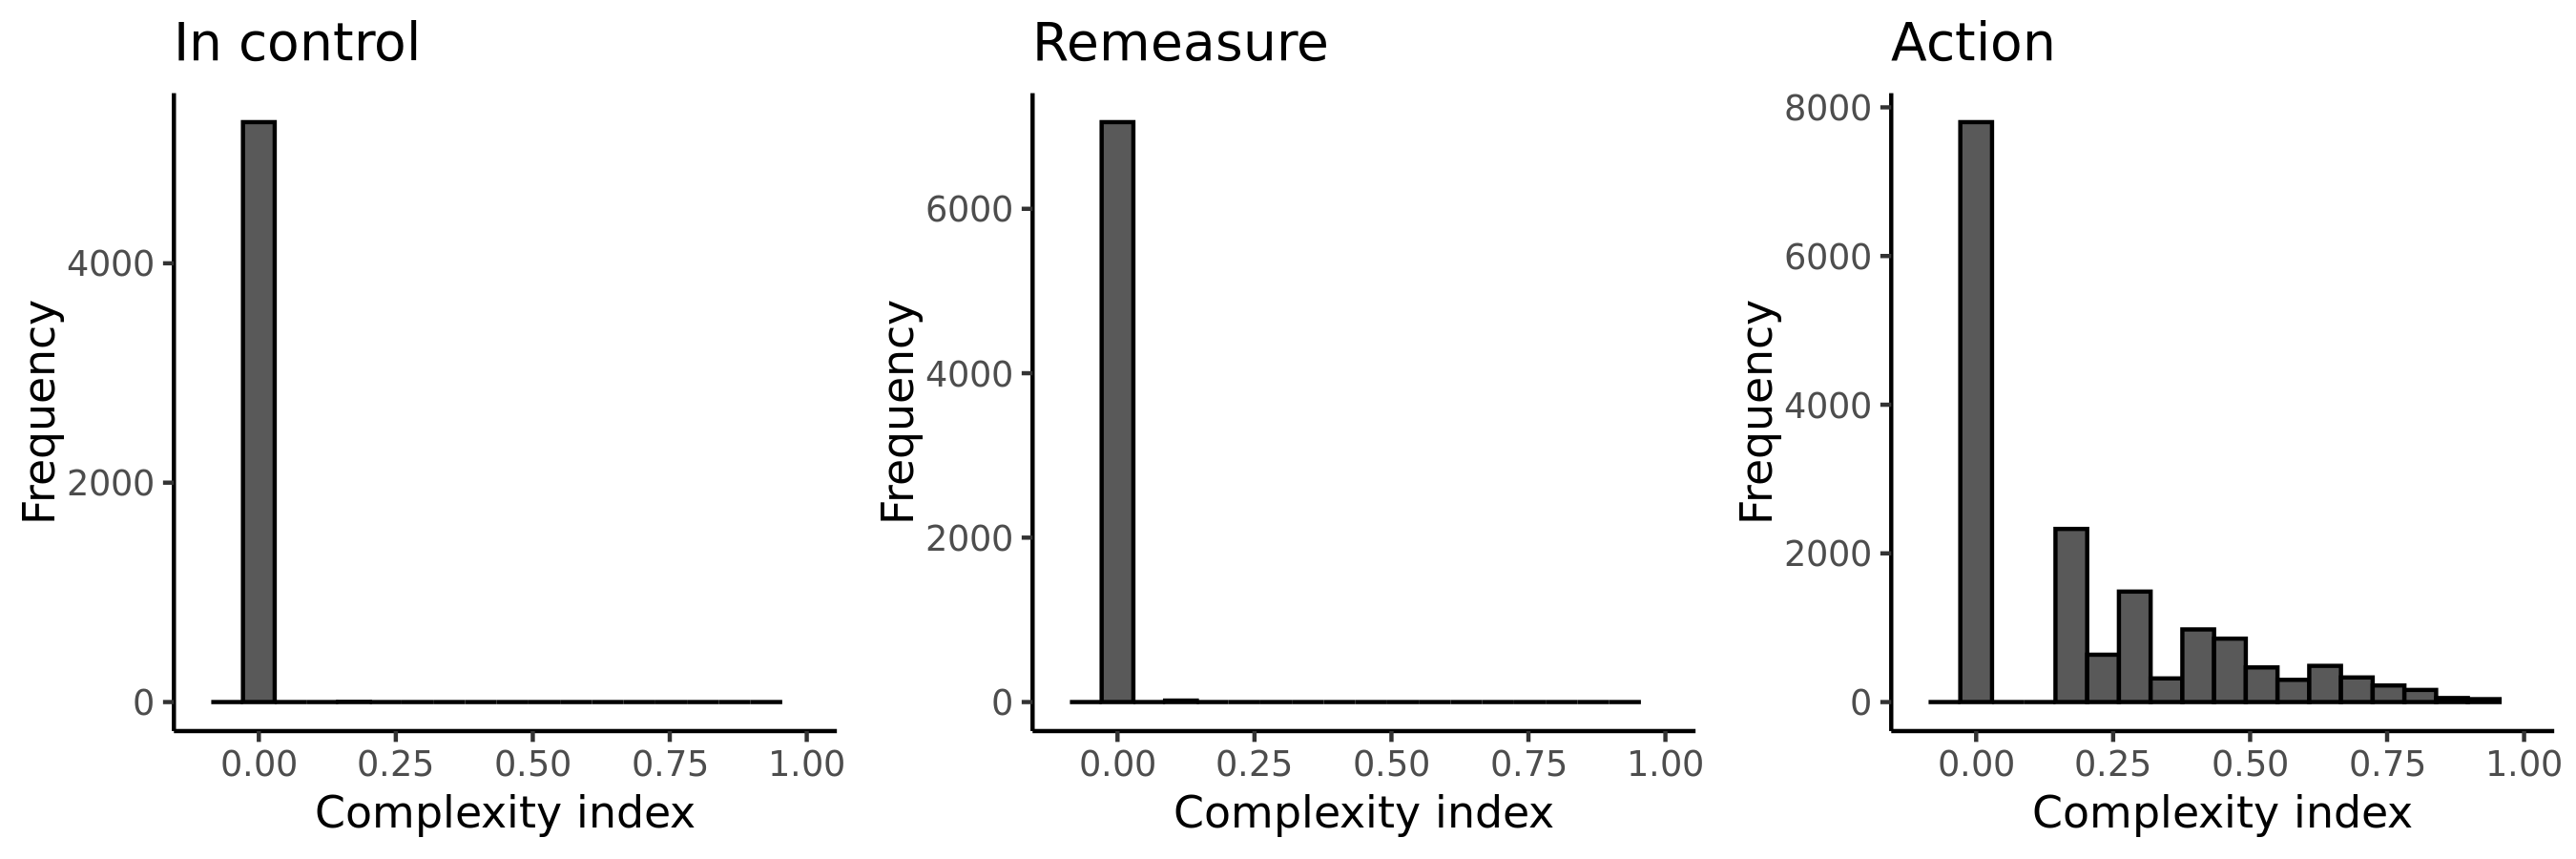

In [20]:
# Plot histograms.
options( repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 300 )
plot_sequenceComplexity_test_only_excludingUnobserved_stratified <- 
    cowplot::plot_grid(
        plot_sequenceComplexity_test_only_Hold
        ,plot_sequenceComplexity_test_only_Monitor
        ,plot_sequenceComplexity_test_only_Adjust
        ,nrow = 1
    )

suppressWarnings( print( plot_sequenceComplexity_test_only_excludingUnobserved_stratified ) )

- The low complexity-index values for the "in control" state subsequences is explained by there being only 13 "in control" subsequence in the entire dataset that was not merely one event long (`person_subsequences_Hold %>% dplyr::filter(pseq_rn != 1) %>% nrow()` = 13). This implies that with only one exception, patient records stayed in the "in control" state for no longer than one inter-test period.

- The low complexity-index values for the "remeasure" state subsequences is explained by test statuses being constant in all but 18 subsequences in the entire dataset (`person_subsequences_Monitor %>% dplyr::group_by( pseq_id ) %>% dplyr::summarise( n_unique_test_status = unique( event_value ) %>% length() ) %>% dplyr::ungroup() %>% dplyr::filter( n_unique_test_status > 1 ) %>% nrow()` = 18). This implies that shorter than expected inter-test intervals were followed by inter-test intervals with expected lengths ("in control") or by changes to prescriptions ("action") as soon as subsequent test status value changed. (To understand the reasoning behind this implication, recall that a test status marks the start of an inter-test period, while the timing (but not the value) of the subsequent test defines the "remeasure" state.)

- The spread of complexity-index values for the "action" state are unsurprising given that most subsequences were "action" subsequences (`df_seq_test_only %>% dplyr::select( person_id, HMA, event_value, rn ) %>% dplyr::group_by( HMA ) %>% dplyr::reframe( n = n() ) %>% dplyr::reframe( HMA = HMA, p = round(  n / sum(n) * 100, 1 ) ) %>% dplyr::filter( HMA == "Adjust" )` = 71% ).

- The large values for the "action" state might be explained by the reasonable expectation that test results change when prescriptions are change, i.e. when action is taken.

- The low values for the "action" state indicates that, most often, prescriptions are changed despite no changes in test status (`seq_complexity_test_only_Adjust %>% as.data.frame() %>% dplyr::filter( C < 0.05 ) %>% tibble::rownames_to_column() %>% dplyr::inner_join( person_subsequences_Adjust, by = join_by( rowname == pseq_id ) ) %>% dplyr::arrange( rowname ) %>% dplyr::filter( pseq_rn != 1 ) %>% dplyr::group_by( rowname ) %>% dplyr::summarise( n_unique_test_status = length( unique( event_value ) ) ) %>% dplyr::filter( n_unique_test_status > 1 ) %>% nrow()` = 29 instances of more than one test status, in the low complexity subgroup)

- The complexity of the test status subsequences in the 'action' state show patient records with greater complexity than that shown in the patient sequences irrespective of state. This can be understood as the test statuses changing frequently relative to the length of the 'action' subsequences compared to the length of patient records' entire sequences.


<br></br>
The state-specific complexity distributions are remarkedly less complex compared to the complexity of sequences irrespective of states (although there is a small presence of highly-complex records in the 'action' state). It must be acknowledged that subsequences are shorter than the the full sequence from a record so there is less opportunity for changes that would contribute to larger values of complexity. (Note that the opportunity for change before a state change is a different concept to the probability of change with respect to the length of a sequence, the latter of which is accounted for in the calculation.) But the length of subsequences does not explain the difference entirely.


One candidate explanation is that test statuses change in coincidence with changes in state rather than during period of stable states. To begin to investigate this explanation, below, I reshow the distribution plot of complexity irrespective of state (left) alongside a plot of complexity for states (right).

In [40]:
# Calculate statistics over all patient records.
seq_complexity_HMA_only <- TraMineR::seqici( sts_seqmine_HMA )

# Create table of summary statistics.
plot_table <-
   seq_complexity_HMA_only %>%
    as.data.frame() %>%
    dplyr::summarise(
        min = min( C )
        ,`1st qtr` = quantile( C, 0.25 )
        ,mean = mean( C )
        ,median = median( C )
        ,`3rd qtr` = quantile( C, 0.75 )
        ,max = max( C )
    ) %>%
    base::round(2) %>%
    t()

# Plot histograms and summary statistics.
options( repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300 )
n_bins <- 20
plot_sequenceComplexity_HMA <-
    seq_complexity_HMA_only %>%
    tibble::as_tibble() %>%
    ggplot() +
    annotation_custom( tableGrob( plot_table ), xmin = 0.5, xmax = 1, ymin = 300, ymax = 900 ) +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "State sequences", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

statistic,All transitions,State transitions
<chr>,<dbl>,<dbl>
min,0.00,0.00
1st qtr,0.12,0.14
mean,0.26,0.32
median,0.27,0.30
3rd qtr,0.38,0.47
max,0.62,0.87


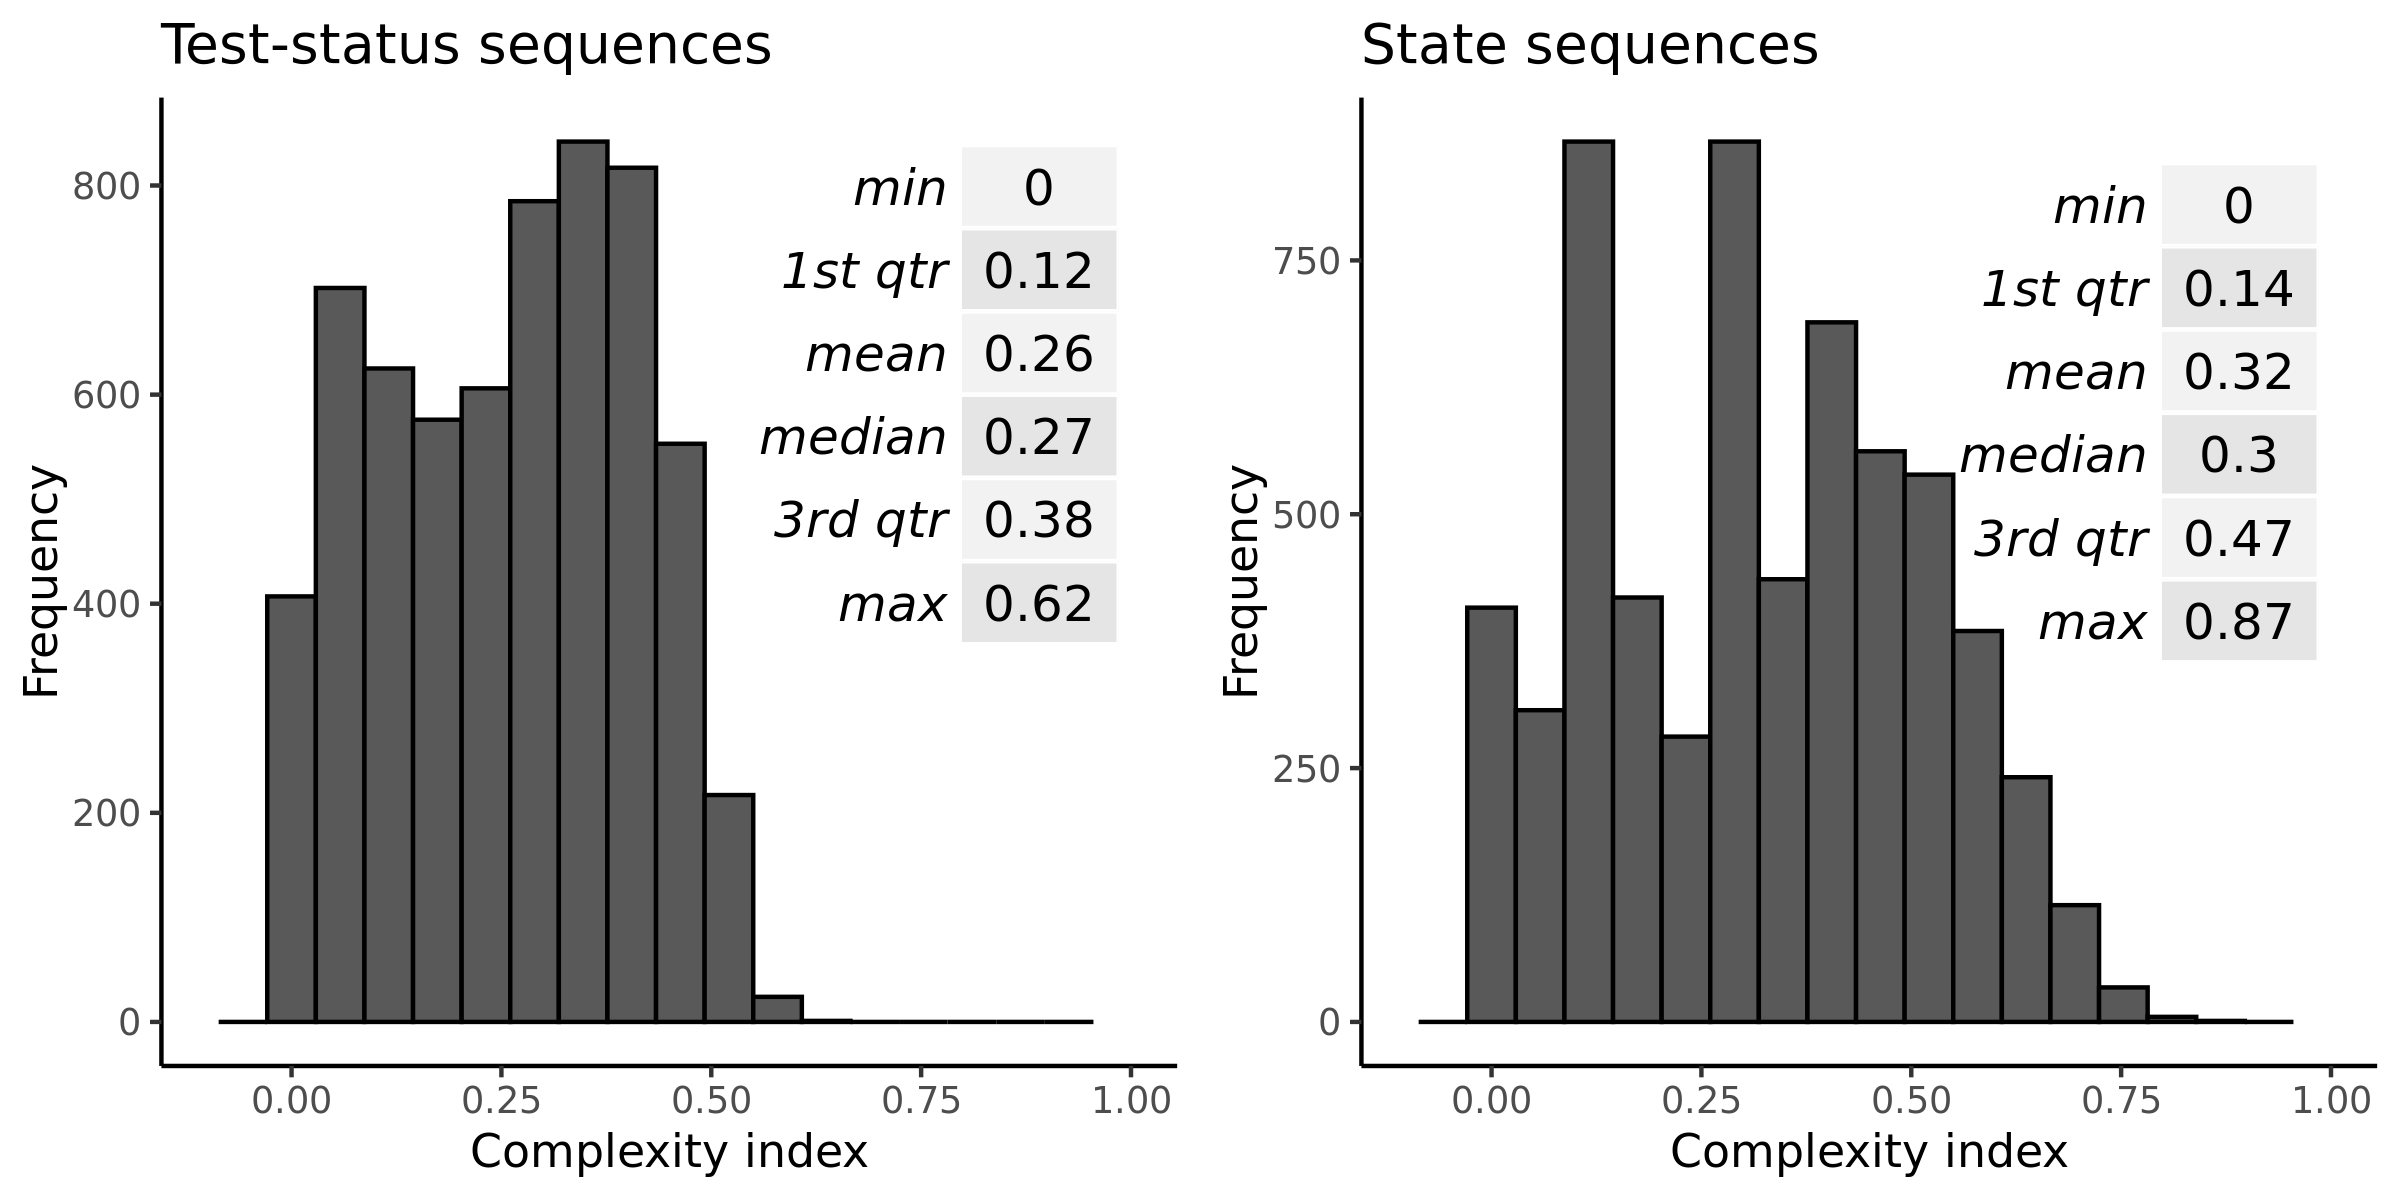

In [42]:
# Plot histograms and summary statistics.
options( repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300 )

suppressWarnings(
    print(
        
        cowplot::plot_grid(
            plot_sequenceComplexity_test_only
            ,plot_sequenceComplexity_HMA
            ,nrow = 1
            )
        )
    )

# Show tables of distributional summary statistics.
dplyr::bind_cols(
    data.frame( statistic = c( "min", "1st qtr", "mean", "median", "3rd qtr", "max" ) )
    ,seq_complexity_test_only %>%
    as.data.frame() %>%
    dplyr::summarise(
        min = min( C )
        ,`1st qtr` = quantile( C, 0.25 )
        ,mean = mean( C )
        ,median = median( C )
        ,`3rd qtr` = quantile( C, 0.75 )
        ,max = max( C )
    ) %>%
    base::round( 2 ) %>%
    t() %>%
    `colnames<-`( "All transitions" )
    ,seq_complexity_HMA_only %>%
    as.data.frame() %>%
    dplyr::summarise(
        min = min( C )
        ,`1st qtr` = quantile( C, 0.25 )
        ,mean = mean( C )
        ,median = median( C )
        ,`3rd qtr` = quantile( C, 0.75 )
        ,max = max( C )
    ) %>%
    base::round( 2 ) %>%
    t() %>%
    `colnames<-`( "State transitions" )
)

- The distributional summary statistics (min, mean, etc.) are similar except for the fatter tail for state sequences with higher complexity.

- The distribution of state-sequence complexity (right) is more spread out.


Despite the qualitative differences between the distributions, they are very similar. Considered in conjunction with the findings from the state-specific complexity indices, and the temporal logic implying that the test statuses influence the states, it is reasonable to conclude that:
1. changes in test status are the main driver of changes in state,
2. states change more often in a patient record than test status does (i.e. testing schedules and treatments are being changed despite no change in test status),
3. only the "action" state is associated with any change to test status, _and_
4. despite conclusion 2, sequences of "action" are mostly associated with no change in test status.

It might also be interesting to the reader to see the distributions of complexity-index values for subsequences of consecutive test status values. Large values would indicate ineffective changes to testing and treatment because it indicates changes to state despite no change to test status.

In [23]:
# Cut the data by test status.
df_seq_test_only_stratified_testStatus <-
    df_seq_test_only %>%
    dplyr::select( person_id, HMA, event_value, rn ) %>%
    base::split( .$event_value)

# Convert the time series dataframe to a state sequence object.
# ## Red
person_subsequences_Red <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Red` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Red <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Red
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Red %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Red, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Red <-
    d_Red %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Red )

# ## Amber
person_subsequences_Amber <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Amber` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Amber <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Amber
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Amber %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Amber, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Amber <-
    d_Amber %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Amber )

# ## Yellow
person_subsequences_Yellow <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Yellow` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Yellow <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Yellow
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Yellow %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Yellow, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Yellow <-
    d_Yellow %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Yellow )

# ## Green
person_subsequences_Green <- 
    df_seq_test_only_stratified_testStatus$`Test Status = Green` %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        diff = rn - lag( rn, default = first( rn ) )
        ,is_new_group = diff != 1
        ,pseq_increment = cumsum( is_new_group )
        ,pseq_id = paste0( person_id, "_", pseq_increment )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( person_id, pseq_increment ) %>%
    dplyr::mutate( pseq_rn = row_number() ) %>%
    as.data.frame() %>%
    dplyr::select( - c( person_id, diff, is_new_group ) )
d_Green <- 
     TraMineRextras::TSE_to_STS(
                person_subsequences_Green
                ,id = "pseq_id"
                ,timestamp = "pseq_rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = person_subsequences_Green %>% dplyr::select( pseq_increment ) %>% dplyr::ungroup() %>% max()
                ) %>%
                dplyr::select( - a1 )
statl <- TraMineR:::seqxtract( d_Green, NULL, data.frame = TRUE ) %>% seqstatl()
sts_seqmine_test_only_Green <-
    d_Green %>%
    TraMineR::seqdef( labels = statl) %>%
    suppressMessages()
rm( d_Green )

In [24]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Green <- TraMineR::seqici( sts_seqmine_test_only_Green )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Green <-
    seq_complexity_test_only_Green %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Green", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [25]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Yellow <- TraMineR::seqici( sts_seqmine_test_only_Yellow )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Yellow <-
    seq_complexity_test_only_Yellow %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Yellow", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [26]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Amber <- TraMineR::seqici( sts_seqmine_test_only_Amber )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Amber<-
    seq_complexity_test_only_Amber %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Amber", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

In [27]:
# Calculate statistics over all patient records.
seq_complexity_test_only_Red <- TraMineR::seqici( sts_seqmine_test_only_Red )

# Plot histograms and summary statistics.
n_bins <- 20
plot_sequenceComplexity_test_only_Red <-
    seq_complexity_test_only_Red %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black", position = "dodge" ) +
    labs( title = "Red", x = "Complexity index", y = "Frequency" ) +
    xlim( -0.1, 1 ) +
    theme_classic()

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


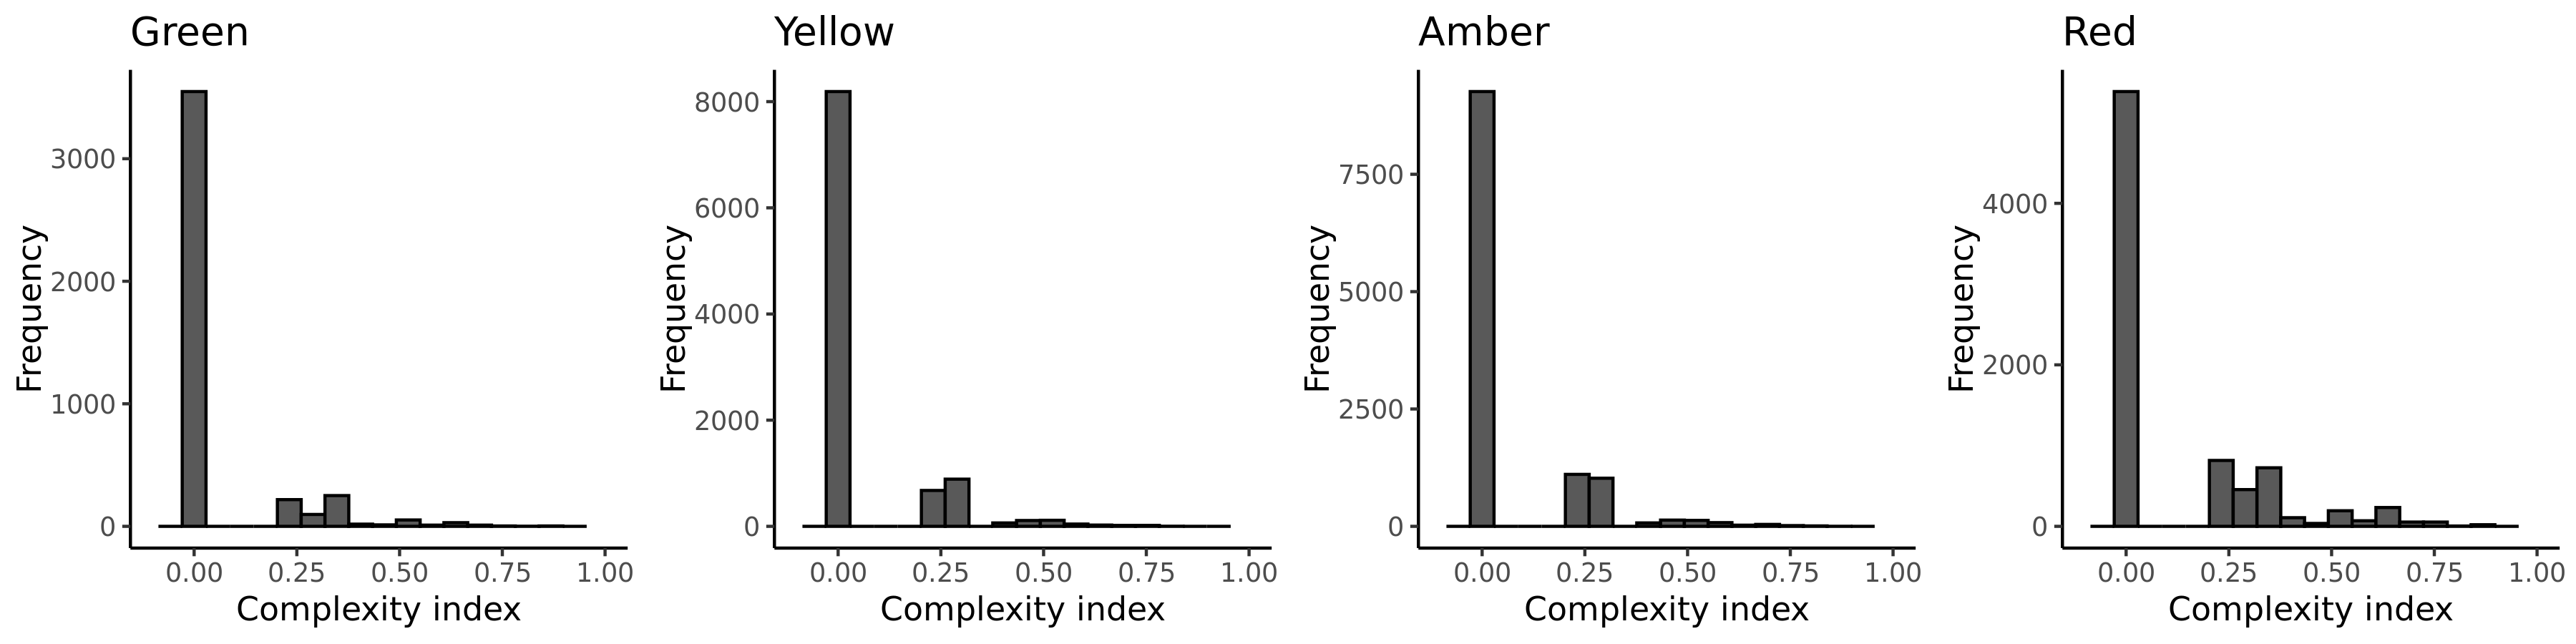

In [28]:
# Plot histograms.
options( repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300 )
plot_sequenceComplexity_test_only_excludingUnobserved_stratified_testStatuses <- 
    cowplot::plot_grid(
        plot_sequenceComplexity_test_only_Green
        ,plot_sequenceComplexity_test_only_Yellow
        ,plot_sequenceComplexity_test_only_Amber
        ,plot_sequenceComplexity_test_only_Red
        ,nrow = 1
    )

suppressWarnings( print( plot_sequenceComplexity_test_only_excludingUnobserved_stratified_testStatuses ) )

- The most common situation across all test status-specific subsequences is to see no change in state. The make sense given that most subsequences are short, which doesn't provide much opportunity for complexity to arise.

- There are instances of moderate and large complexity subsequences in all test-status strata, meaning that testing schedules and treatments are changing considerably despite unchanging test statuses.


We conclude:
1. Given that this analysis looks at 10-year sequences starting 10 years after diagnosis, ...